In [1]:
import os
from os.path import join as jp
import json
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from collections import defaultdict
from typing import Sequence, Callable

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import matplotlib.lines as mlines
from pylab import rc
# from skimage.measure import label
import seaborn as sns
from scipy import stats

from dpipe.io import load, save_json, load_json, load_pred, save
from dpipe.dataset.wrappers import apply, cache_methods
from dpipe.im.metrics import dice_score, iou, fraction
from dpipe.commands import load_from_folder
from dpipe.im.box import get_centered_box
from dpipe.im.shape_ops import crop_to_box
from dpipe.itertools import zip_equal
from ood.batch_iter.pipeline import SPATIAL_DIMS, sample_center_uniformly
from ood.metric.metric import exp2froc_df as exp2prc_df, get_froc as get_prc, get_size_df
from ood.utils import np_sigmoid, get_pred, sdice, volume2diameter, get_pred
from ood.metric.ood_metric import calc_ood_scores, get_entropy, get_mutual_info, get_inconsistency_metrics

import matplotlib.pyplot as plt
%matplotlib inline


voxel_spacing = (1, 0.95, 0.95)
in_distr_id = 2
n_folds = 6
ood_folds = [i for i in range(n_folds) if i != in_distr_id]
n_seeds = 3
bin_threshold = 0.5
eps = 1e-8

SEGMENTATION_METRICS = ['dice_score', 'sdice_score', 'froc_records']
SINGLE_NN_OOD_METRICS = ['maxprob', 'entropy']
TOP_N_VOXELS = 500000

#### Functions to calculate AUFROC and avg FP

In [2]:
def f_luna(d):
    if d < 8:
        return 'small'
    else:
        return 'large'
    
    
def path2title(exp_path):
    if 'luna' in exp_path:
        return 'LUNA16'
    elif 'lits' in exp_path:
        return 'LiTS'


def bootstrap_prc_df(df, n_ids, thresholds, with_logits=False, n_iter=50, sample_fraction=0.8, seed=42):
    ids = np.unique(df['id'])
    n_samples = int(len(ids) * sample_fraction)
    rs = np.random.RandomState(seed=seed)
    
    prcs = []
    for n in range(n_iter):
        rs.shuffle(ids)
        iter_ids = ids[:n_samples]
        iter_df = df[np.array([True if _id in iter_ids else False for _id in df['id']])]
        
        if with_logits:
            prc_iter = get_prc(iter_df, thresholds=thresholds, self_stat='self_logit', hit_stat='hit_logit')
        else:
            prc_iter = get_prc(iter_df, thresholds=thresholds)
            
        prc_iter['avgFP'] = np.array(prc_iter['totalFP']) / n_ids
        
        prcs.append(prc_iter)
        
    return prcs


def average_prcs(prcs, axis, max_fp=6):
    x_points = np.linspace(0, max_fp, 100)
    ys = []
    for prc in prcs:
        ys.append(np.interp(x_points, prc[axis[0]][::-1], prc[axis[1]][::-1]))
        
    ys = np.array(ys)
    mean_y = np.mean(ys, axis=0)
    std_y = np.std(ys, axis=0)
    
    return x_points, mean_y, std_y


# ================================================================================================================
    
    
def prc2luna_metric(prc, axis, max_fp):
    # luna metric
    assert axis[0] == 'avgFP' and axis[1] == 'recall'
    
    prc0, prc1 = list(prc[axis[0]]), list(prc[axis[1]])
    prc0.append(0)
    prc1.append(0)
    x_points = np.linspace(0, max_fp, max_fp*100+1)
    luna_metric = np.mean(np.interp(x_points, prc0[::-1], prc1[::-1]))
        
    return luna_metric
        
        
# ================================================================================================================


def plot_froc(exp_path, inst='total', with_metric=False, with_logits=True):
    
    # ### SETUP OF FROC ###
    is_luna = 'luna' in exp_path
    label = 'dl'
    
    axis=['avgFP', 'recall']
    label2label = {'bce': 'BCE', 'iwbce': 'BCE + iw',
                   'asl': 'ASL', 'iwasl': 'ASL + iw',
                   'fl': 'Focal Loss', 'iwfl': 'Focal Loss + iw',
                   'dl': 'Dice Loss', 'iwdl': 'Dice Loss + iw'}
    label2color = {'bce': '#2274A5', 'iwbce': '#2274A5',
                   'asl': '#E83F6F', 'iwasl': '#E83F6F',
                   'fl': '#32936F', 'iwfl': '#32936F',
                   'dl': '#FFBF00', 'iwdl': '#FFBF00'}
    linestyle = '-' if 'iw' in label else '--'

    thresholds = np_sigmoid(np.linspace(-0.1, 10, num=51))
        
    
    # ### load df ###
    n_val = len([exp_n for exp_n in os.listdir(exp_path) if 'experiment_' in exp_n])
    df = exp2prc_df(exp_path, n_val=n_val)
    n_ids = len(load_json(jp(exp_path, 'experiment_0/test_metrics/froc_records.json')))
    
    f_dim = f_luna
    df['size'] = df['diameter'].apply(f_dim)
    
    df.reset_index(inplace=True, drop=True)
    
    df_inst = get_size_df(df, size=inst)
    df = get_size_df(df, size=inst)    
    
    if with_logits:
        max_logit = np.max(df[(df['self_logit'] > -np.inf) & (df['self_logit'] < np.inf)]['self_logit'])
        thresholds = np.concatenate((np.linspace(-0.1, 10, num=101), np.linspace(10, max_logit+1, num=100)))
        prc = get_prc(df, thresholds=thresholds, hit_stat='hit_logit', self_stat='self_logit')
    else:
        thresholds = np_sigmoid(np.linspace(0, 10, num=51))
        prc = get_prc(df, thresholds=thresholds)
     
    prc['avgFP'] = np.array(prc['totalFP']) / n_ids
        
    prcs = bootstrap_prc_df(df, n_ids, thresholds, with_logits=with_logits)

    results = {}
    # ### metrics calculation (only with total size (i == 1)) ###
    if with_metric and inst == 'total':
        # object-wise Dice Score
        avg_dice, std_dice = prc['avg_dice'][0], prc['std_dice'][0]
        results['avg_object_dice'] = avg_dice
        results['std_object_dice'] = std_dice
        print(path2title(exp_path), label, '(object Dice):', f'{avg_dice:.2f}', '+-', f'{std_dice:.2f}')

        # avg-std for luna metric:
        max_fp = 5
        luna_metrics = []
        for _prc in prcs:
            luna_metrics.append(prc2luna_metric(_prc, axis, max_fp))
        print(path2title(exp_path), label, 
              '(avg Recall):', f'{np.mean(luna_metrics):.2f}', '+-', f'{np.std(luna_metrics):.2f}')

        results['avg_recall'] = np.mean(luna_metrics)
        results['std_recall'] = np.std(luna_metrics)
        results['AvgFP'] = prc['avgFP'][0]
        results['Frac_empty_preds'] = 1 - len(np.unique(df['id'])) / n_ids
        print(' ')
        
    save_json(results, jp(exp_path, 'experiment_0/test_metrics/froc_metrics.json'))


def experiments2plot(with_metric=False, with_logits=True):

    luna_paths1 = [os.path.join(luna_path, f'seed{seed}') for seed in range(3)]
    
    paths = [[luna_paths1]]
      
    for i in range(len(paths[0])):
        for j in range(len(paths[0][0])):
            path = paths[0][i][j]
            print(path)
            plot_froc(path, with_metric=with_metric, with_logits=with_logits)

In [3]:
# luna_path = '/shared/experiments/ood_playground/lidc/ct_ich/'
# experiments2plot(with_metric=True)

#### Functions for OOD scores calculation

In [13]:
def get_score_augmentation(true_labels, augm_labels, print_results=True, is_segm_metric=False, 
                           calc_corr=False, id_metrics=None, ood_metrics=None):

    scores = np.array(list(true_labels.values()) + list(augm_labels.values()))
    y_true = np.array([False] * len(true_labels) + [True] * len(augm_labels))
    
    if is_segm_metric:
        y_true = ~y_true
        
    det_acc, auroc, tnr = calc_ood_scores(scores, y_true, print_results=print_results)
        
    if calc_corr:
        metrics = [id_metrics[uid] for uid in true_labels.keys()] + \
                  [ood_metrics[uid] for uid in augm_labels.keys()]
        correlation = abs(stats.pearsonr(metrics, scores)[0])
        return det_acc, auroc, tnr, correlation
    
    return det_acc, auroc, tnr

def get_correlation(metrics, ood_scores):
    metrics = [metrics[uid] for uid in ood_scores.keys()]
    correlation = abs(stats.pearsonr(metrics, list(ood_scores.values()))[0])
    return correlation

def filter_metrics(metrics, ids):
    return {uid: metrics[uid] for uid in ids}

def filter_metrics_crops(metrics):
    return metrics
#     return {uid: metrics[uid] for uid in metrics.keys() if uid.endswith('_1')}


def add_row(result_df, row_list):
    for i in range(len(row_list)):
        if type(row_list[i]) == np.float64:
            row_list[i] = np.round(row_list[i], 3)
    result_df.loc[result_df.shape[0]] = row_list


def calc_ood_statistics_new_dataset(result_df, ind_exp_dir, ood_exp_dir, method_name, ind_ids=None, 
                                    has_single_ue_scores=True, has_incosnsistency_scores=True,
                                    calc_corr=False, corr_segm_metric=None):
        
    metric_file = os.listdir(ind_exp_dir)[0]
    ind_labels = load(os.path.join(ind_exp_dir, metric_file))
    if ind_ids is None:
        ind_ids = list(ind_labels.keys())

    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            
            # TODO REMOVE
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
            
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(ind_exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS:# or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            
            if not os.path.exists(os.path.join(ood_exp_dir, metric_name + '.json')):
                print(f'skipping {metric_name} - file not found')
                continue
                
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            if np.isnan(np.array(list(ood_labels.values())).astype(float)).any():
                print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
                continue
            if np.isnan(np.array(list(ind_labels.values())).astype(float)).any():
                print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
                continue
                
            # TODO REMOVE    
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
                            
            if calc_corr:
                if not method_name.startswith('Deep Ensembles'):
                    num_folders = 4
                else:
                    num_folders = 1
                id_metrics = load(os.path.join('/'.join(ind_exp_dir.split('/')[:-num_folders]), 
                                            'seed0/experiment_0/test_metrics', corr_segm_metric + '.json'))
                id_metrics = filter_metrics(id_metrics, ind_ids)
                ood_metrics = load(os.path.join('/'.join(ood_exp_dir.split('/')[:-num_folders]), 
                                            'seed0/experiment_0/test_metrics', corr_segm_metric + '.json'))
            else:
                id_metrics = None
                ood_metrics = None
                
            ood_results = list(get_score_augmentation(ind_labels, ood_labels, print_results=False, 
                                                      calc_corr=calc_corr, id_metrics=id_metrics, 
                                                      ood_metrics=ood_metrics))

            if calc_corr:
                add_row(result_df, [method_name, metric_name, ood_results[0], ood_results[1], 
                                    ood_results[2], ood_results[4]])
            else:
                add_row(result_df, [method_name, metric_name, ood_results[0], ood_results[1], ood_results[2]])
            
            
def calc_ood_statistics(result_df, method_name, exp_dir, in_distr_id, uid_folds,
                        has_single_ue_scores=True, has_incosnsistency_scores=True,
                        calc_corr=False, corr_segm_metric=None):
    
    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            labels = load(os.path.join(exp_dir, metric_name + '.json'))
            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            
            if calc_corr:
                if not method_name.startswith('Deep Ensembles'):
                    num_folders = 4
                else:
                    num_folders = 1
                metrics = load(os.path.join('/'.join(exp_dir.split('/')[:-num_folders]), 
                                            'seed0/experiment_0/test_metrics', corr_segm_metric + '.json'))
                corr = get_correlation(metrics, labels)
                add_row(result_df, [method_name, metric_name, det_acc, auc, tnr, corr])
            else:
                add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS:# or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            
            labels = load(os.path.join(exp_dir, metric_file))
            if not method_name.startswith('Deep Ensembles'):
                # drop train ids from labels
                train_ids = load('/'.join(exp_dir.split('/')[:-2]) + '/train_ids.json')
                labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            if calc_corr:
                if not method_name.startswith('Deep Ensembles'):
                    num_folders = 4
                else:
                    num_folders = 1
                metrics = load(os.path.join('/'.join(exp_dir.split('/')[:-num_folders]), 
                                            'seed0/experiment_0/test_metrics', corr_segm_metric + '.json'))
                corr = get_correlation(metrics, labels)
                add_row(result_df, [method_name, metric_name, det_acc, auc, tnr, corr])
            else:
                add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def calc_ood_statistics_mood(result_df, method_name, exp_dir, is_ood_id):

    for metric_file in tqdm(os.listdir(exp_dir)):
        metric_name = metric_file.split('.json')[0]
        if metric_name in SEGMENTATION_METRICS:
            continue

        labels = load(os.path.join(exp_dir, metric_file))
        is_ood_true = np.array([is_ood_id[uid] for uid in labels.keys()])
        labels_arr = np.array(list(labels.values()))
        if np.isnan(labels_arr).astype(float).any():
            print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
            continue
        # sorted_ids = np.argsort(labels_arr)
        # print(method_name, metric_name)
        # print(labels_arr[sorted_ids])
        # print(is_ood_true[sorted_ids])
        
        det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
        add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def get_segm_drops(experiment_dir, uid_folds, segm_metrics=['dice_score', 'sdice_score'], seeds=range(n_seeds)):

    print('SEGMENTATION DROPS')
    for metric_name in segm_metrics:
        
        print(f'\n{metric_name}')

        ood_metrics = np.zeros((n_folds, len(seeds)))

        for seed in seeds:
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/')
            metrics = load(os.path.join(base_dir, 'test_metrics', f'{metric_name}.json'))

            ids = set(uid_folds[uid_folds == in_distr_id].index)
            metric_keys = set(metrics.keys())
            ids = metric_keys.intersection(ids)

            in_distr_metric = np.mean([metrics[uid] for uid in ids])
            ids = list(ids)
            ood_metrics[in_distr_id, seed] = in_distr_metric

            for fold_id in ood_folds:
                ids = list(uid_folds[uid_folds == fold_id].index)

                ood_metric = np.mean([metrics[uid] for uid in ids])
                ood_metrics[fold_id, seed] = ood_metric

        means = ood_metrics.mean(axis=1)
        stds = ood_metrics.std(axis=1)
        drops = ood_metrics[in_distr_id] - ood_metrics[ood_folds].mean(axis=0)

        print(f'In distr:\t\t{means[in_distr_id]:.4f} ± {stds[in_distr_id]:.4f}')
        print(f'OOD:\t\t\t{ood_metrics[ood_folds].mean():.4f} ± {ood_metrics[ood_folds].std():.4f}')
        print(f'{metric_name} drop:\t{drops.mean():.4f} ± {drops.std():.4f}')
        
        
def get_baseline_results(result_df, experiment_dir, method_name, uid_folds, seeds=range(n_seeds),
                         calc_corr=False, corr_segm_metric=None):
    for ue_method in['maxprob', 'entropy']:
        det_accs = []
        roc_aucs = []
        tprs = []
        labels_list = []
        corrs = []

        for seed in seeds:
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_predictions')
            labels = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/{ue_method}.json'))
            labels_list.append(labels)

            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, roc_auc, tpr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, 
                                                    print_results=False)
            det_accs.append(det_acc)
            roc_aucs.append(roc_auc)
            tprs.append(tpr)
            
            if calc_corr:
                metrics = load(os.path.join(experiment_dir, 
                                            f'seed{seed}/experiment_0/test_metrics/{corr_segm_metric}.json'))
                corr = get_correlation(metrics, labels)
                corrs.append(corr)
        
        if calc_corr:
            add_row(result_df, [method_name, ue_method, np.mean(det_accs), np.mean(roc_aucs),
                                np.mean(tprs), np.mean(corrs)])
        else:
            add_row(result_df, [method_name, ue_method, np.mean(det_accs), np.mean(roc_aucs),
                            np.mean(tprs)])

        
def get_drops_and_baselines_new_dataset(result_df, method_name, ind_experiment_dir, ood_experiment_dir,
                                        seeds=range(n_seeds), has_segm_metrics=True, segm_metrics=None, 
                                        ind_ids=None, calc_froc=False, segm_metrics_froc=None,
                                        calc_corr=False, corr_segm_metric=None):
    
    if segm_metrics is None:
        segm_metrics = ['dice_score', 'sdice_score']
    ue_metrics = ['maxprob', 'entropy']
    
    if ind_ids is None:
        ind_ids = list(load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metrics[0]}.json')).keys())
    
    if calc_froc:
        ind_segms = {metric: [] for metric in segm_metrics + segm_metrics_froc}
        ood_segms = {metric: [] for metric in segm_metrics + segm_metrics_froc}
        drops = {metric: [] for metric in segm_metrics + segm_metrics_froc}
    else:
        ind_segms = {metric: [] for metric in segm_metrics}
        ood_segms = {metric: [] for metric in segm_metrics}
        drops = {metric: [] for metric in segm_metrics}
        
    ood_metrics = {metric: [] for metric in ue_metrics}
            
    for seed in seeds:
        ind_exp_dir = os.path.join(ind_experiment_dir, f'seed{seed}/experiment_0/')
        ood_exp_dir = os.path.join(ood_experiment_dir, f'seed{seed}/experiment_0/')
        
        if has_segm_metrics:
            for segm_metric in segm_metrics:
                if segm_metric.split('_')[-1] == 'padded':
                    segm_metric_ind = '_'.join(segm_metric.split('_')[:-1])
                else:
                    segm_metric_ind = segm_metric
                ind_segm_metrics = load(os.path.join(ind_exp_dir, f'test_metrics/{segm_metric_ind}.json'))
                ood_segm_metrics = load(os.path.join(ood_exp_dir, f'test_metrics/{segm_metric}.json'))
                ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_ids]) # filter uids
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                
                # TODO REMOVE
#                 ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_ids if uid.endswith('_1')]) # filter uids
                ood_segm_metrics = filter_metrics_crops(ood_segm_metrics)
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                
                ind_segms[segm_metric].append(ind_segm)
                ood_segms[segm_metric].append(ood_segm)
                drops[segm_metric].append(ind_segm - ood_segm)
                
            if calc_froc:
                ind_froc_results = load(os.path.join(ind_exp_dir, f'test_metrics/froc_metrics.json'))
                ood_froc_results = load(os.path.join(ood_exp_dir, f'test_metrics/froc_metrics.json'))
                
                # TODO REMOVE
#                 ind_froc_results = filter_metrics_crops(ind_froc_results)
                ood_froc_results = filter_metrics_crops(ood_froc_results)
                
                for segm_metric in segm_metrics_froc:
                    if segm_metric.split('_')[-1] == 'padded':
                        segm_metric_ind = '_'.join(segm_metric.split('_')[:-1])
                    else:
                        segm_metric_ind = segm_metric
                        
                    ind_segm = ind_froc_results[segm_metric_ind]
                    ood_segm = ood_froc_results[segm_metric]
                    ind_segms[segm_metric].append(ind_segm)
                    ood_segms[segm_metric].append(ood_segm)
                    drops[segm_metric].append(ind_segm - ood_segm)
            
        for ue_metric in ue_metrics:
            ind_labels = load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metric}.json'))
            ood_labels = load(os.path.join(ood_exp_dir, f'test_metrics/{ue_metric}.json'))
            ind_labels = {uid: ind_labels[uid] for uid in ind_ids} # filter uids
            
            # TODO REMOVE
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
            
            if calc_corr:
                id_metr = load(os.path.join(ind_exp_dir, f'test_metrics/{corr_segm_metric}.json'))
                ood_metr = load(os.path.join(ood_exp_dir, f'test_metrics/{corr_segm_metric}.json'))
            else:
                id_metr = None
                ood_metr = None
                
            ood_results = list(get_score_augmentation(ind_labels, ood_labels, print_results=False, 
                                                      calc_corr=calc_corr, id_metrics=id_metr, 
                                                      ood_metrics=ood_metr))

            ood_metrics[ue_metric].append(ood_results)
    
    if has_segm_metrics:
        for metric_name in drops.keys():
            cur_ind_segm = np.array(ind_segms[metric_name])
            cur_ood_segm = np.array(ood_segms[metric_name])
            cur_drop = np.array(drops[metric_name])
            print(f'\n{metric_name}')
            print(f'In distr:\t\t{cur_ind_segm.mean():.4f} ± {cur_ind_segm.std():.4f}')
            print(f'OOD:\t\t\t{cur_ood_segm.mean():.4f} ± {cur_ood_segm.std():.4f}')
            print(f'{metric_name} drop:\t{cur_drop.mean():.4f} ± {cur_drop.std():.4f}')
        
    for ue_metric in ue_metrics:
        cur_metric = np.array(ood_metrics[ue_metric])
        means = cur_metric.mean(axis=0)
        if calc_corr:
            add_row(result_df, [method_name, ue_metric, means[0], means[1], means[2], means[4]])
        else:
            add_row(result_df, [method_name, ue_metric, means[0], means[1], means[2]])

In [14]:
def filter_identity(results_data):
    return results_data.sort_values('AUROC', ascending=False)


def filter_iou_top_n(results_data):
#     return results_data

    # return results_data[results_data.agg_function.isin(['var', 'maxprob', 'entropy', '1_min_distance', '2_min_distance', 
    #                                                     'pnml_regret', 'min_distance_init', 'min_distance', 'mut_info'
    #                                                     ])]#.sort_values('AUROC', ascending=False)

    return results_data[~results_data.agg_function.isin(['mean_iou', 'top_n_500000_std', 'top_n_500000_var', 
                                                         'top_n_1000000_std', 'top_n_1000000_var', 'top_n_2000000_std', 'top_n_2000000_var',
                                                         'mean_distance_init', 'mean_distance_scale', 'mean_distance_norm',
                                                         'distance_from_center_init', 'distance_from_center_scale', 'distance_from_center_norm',
                                                         '5_percentile_init', '5_percentile_norm', '5_percentile_scale', 
                                                         'isolation_forest_scale', 'isolation_forest_norm', 'isolation_forest_init',
                                                         'entropy',
                                                         'mean_volume', 'mean_dice',
                                                         'mut_info', #'min_distance_scale', 'min_distance_norm',
                                                         'min_distance_full_norm', 'min_distance_full_scale', 'min_distance_full_init',
                                                         'mahalanobis_full_norm', 'mahalanobis_full_scale', 'mahalanobis_full_init',
                                                         'LOF_5_init', 'LOF_10_init', 'LOF_20_init',
                                                         'LOF_5_scale', 'LOF_10_scale', 'LOF_20_scale',
                                                         'std',
                                                         #'mahalanobis_norm', 'mahalanobis_scale',
                                                        ])].sort_values('AUROC', ascending=False)


def get_all_metrics(exp_dir, filter_func, data_name, methods_dict, uid_folds, segm_metrics, 
                    in_distr_id=in_distr_id, seeds=range(n_seeds), calc_corr=False, corr_segm_metric=None):
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    get_segm_drops(exp_dir, uid_folds=uid_folds, segm_metrics=segm_metrics, seeds=seeds)
    get_baseline_results(results_data, experiment_dir=exp_dir, method_name='Baseline', 
                         uid_folds=uid_folds, seeds=seeds, 
                         calc_corr=calc_corr, corr_segm_metric=corr_segm_metric)
    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        if not method_folder.startswith('final_metrics'):
            ind_exp_dir = os.path.join(exp_dir, method_folder, 'experiment_0/test_metrics/')
        else:
            ind_exp_dir = os.path.join(exp_dir, method_folder)
        calc_ood_statistics(results_data, method_name, ind_exp_dir, 
                            in_distr_id=in_distr_id, uid_folds=uid_folds,
                            has_single_ue_scores=False, has_incosnsistency_scores=True,
                            calc_corr=calc_corr, corr_segm_metric=corr_segm_metric)

    print('\n' + data_name)
    return filter_func(results_data)


def get_all_metrics_mood(exp_dir, filter_func, data_name, methods_dict, is_ood_id):
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        ind_exp_dir = os.path.join(exp_dir, method_folder, 'experiment_0/test_metrics')
        calc_ood_statistics_mood(results_data, method_name, ind_exp_dir, is_ood_id)

    print('\n' + data_name)
    return filter_func(results_data)


def get_all_metrics_new_dataset(ind_experiment_dir, ood_experiment_dir, filter_func, data_name, methods_dict,
                                segm_metrics=None, ind_ids_type=None, cc359_dataset_folds=None, 
                                has_segm_metrics=True,
                                in_distr_id=in_distr_id, seeds=range(n_seeds), calc_froc=False,
                                segm_metrics_froc=None, calc_baseline=True, calc_corr=False, corr_segm_metric=None):
    
    ind_ids = load(os.path.join(ind_experiment_dir, 'seed0/experiment_0/test_ids.json'))
    if ind_ids_type == 'CC359':
        ind_ids = [uid for uid in ind_ids if cc359_dataset_folds[uid] == in_distr_id] 
            
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    
    if calc_baseline:
        get_drops_and_baselines_new_dataset(results_data, method_name='Baseline', 
                                            ind_experiment_dir=ind_experiment_dir, 
                                            ood_experiment_dir=ood_experiment_dir, seeds=seeds, 
                                            has_segm_metrics=has_segm_metrics,
                                            segm_metrics=segm_metrics, ind_ids=ind_ids, calc_froc=calc_froc,
                                            segm_metrics_froc=segm_metrics_froc,
                                            calc_corr=calc_corr, corr_segm_metric=corr_segm_metric)

    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        if method_folder.startswith('final_metrics'):
            ind_exp_dir = os.path.join(ind_experiment_dir, method_folder)
            ood_exp_dir = os.path.join(ood_experiment_dir, method_folder)
        elif len(method_folder.split('/')) > 1:
            method_folder_short = '/'.join(method_folder.split('/')[6:])
            print(method_folder_short)
            ind_exp_dir = os.path.join(method_folder, 'experiment_0/test_metrics/')
            ood_exp_dir = os.path.join('/homes/dfrolova/ood-playground/notebooks/luna_flip/', method_folder_short, 'experiment_0/test_metrics/') 
            print(ind_exp_dir, ood_exp_dir)
        else:
            ind_exp_dir = os.path.join(ind_experiment_dir, method_folder, 'experiment_0/test_metrics/')
            ood_exp_dir = os.path.join(ood_experiment_dir, method_folder, 'experiment_0/test_metrics/') 
         
        calc_ood_statistics_new_dataset(results_data, ind_exp_dir, ood_exp_dir, method_name, ind_ids=ind_ids, 
                                        has_single_ue_scores=False, has_incosnsistency_scores=True,
                                        calc_corr=calc_corr, corr_segm_metric=corr_segm_metric)

    print('\n' + data_name)
    return filter_func(results_data)

## Visualization of OOD scores from the paper

In [6]:
fold2domain_name = {0: 'Siemens 1.5T', 1: 'Siemens 3T', 2: 'GE 1.5T', 3: 'GE 3T', 4: 'Philips 1.5T', 5: 'Philips 3T'}
domain2marker = {0: 'o', 1: 'd', 2: 'P', 3: 'v', 4: 's', 5: '*'}
max_domain_name_len = 12


def visualize_ood_statistics_folds(labels, metrics):
    fontsize = 24
    
    ood_metrics = np.zeros((n_folds))

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id] = in_distr_metric
    print(f'In distribution: {in_distr_metric:.4f}')

    for fold_id in ood_folds:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id] = ood_metric
        print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    labels_arr = np.array(list(labels.values()))
    folds = np.array([dataset.df.fold[uid] for uid in labels.keys()])
    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
    sorted_ids = np.argsort(labels_arr)

    ordered_metrics = {uid: metrics[uid] for uid in labels.keys()}
    ordered_metrics_arr = np.array(list(ordered_metrics.values()))

    lab_folds = []
    for fold in folds:
        label = f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}'
        if fold == in_distr_id:
            label = f'{fold}: In-distribution'
        lab_folds.append(label)
            
            
    data=pd.DataFrame(np.concatenate([labels_arr[:, None], 
                                      ordered_metrics_arr[:, None]], axis=1))
    data['domains'] = lab_folds
        
    data = data.sort_values(['domains'])
    
    data.columns = ['a', 'b', 'Domains']
    # plt.figure(figsize=(15, 6))
    #sns.lmplot(data=data, x='a', y='b', hue='Domains', aspect=2)
        
    for domain_name in np.unique(data['Domains']):
        cur_data = data[data['Domains'] == domain_name]
        domain_name_new = fold2domain_name[int(domain_name[0])] + ':' + ' ' * \
                          (max_domain_name_len - len(fold2domain_name[int(domain_name[0])]) + 1) + domain_name[3:]
        sns.regplot(cur_data['a'], cur_data['b'], label=domain_name_new, ci=None, line_kws={'linewidth': 3}, 
                    marker=domain2marker[int(domain_name[0])], scatter_kws={'s': 50})
    
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    #specify order of items in legend
    order = [2, 3, 0, 1, 4, 5]

    #add legend to plot
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop={'family': 'DejaVu Sans Mono'})
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.xlabel('Uncertainty score', fontsize=fontsize)
    plt.ylabel('Surface Dice Score', fontsize=fontsize)
    plt.show()

In [17]:
# sns.set();
sns.set(rc={'figure.figsize':(20,8.27)}, font_scale=2)

In [18]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/cc359/'
dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)

NameError: name 'Rescale3D' is not defined

In distribution: 0.9528
OOD fold 0: 0.8998
OOD fold 1: 0.8651
OOD fold 3: 0.7827
OOD fold 4: 0.9494
OOD fold 5: 0.8456


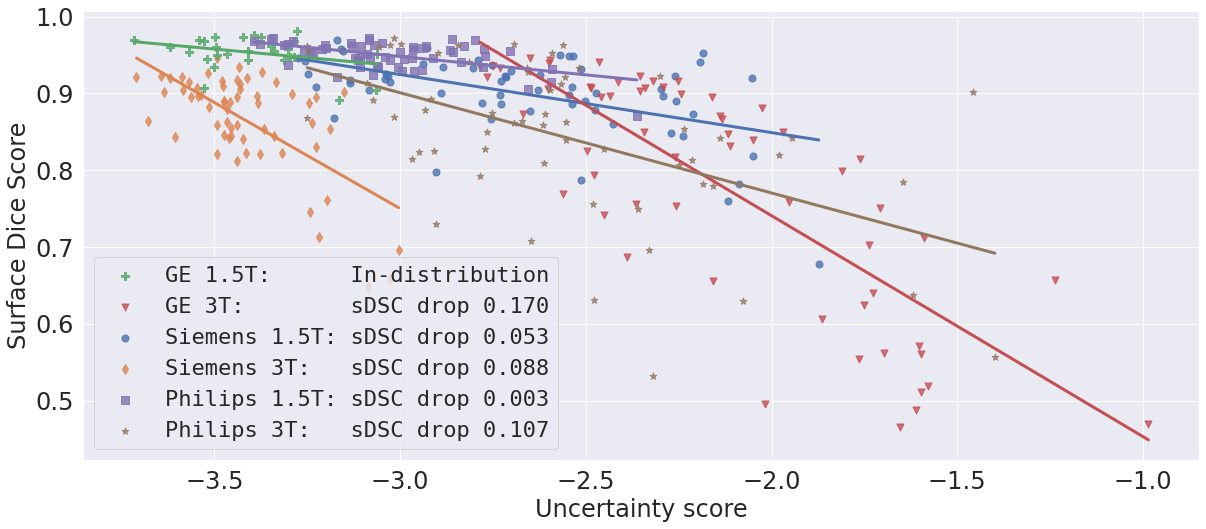

In [134]:
seed = 0
labels = load(os.path.join(experiment_dir, f'godin/experiment_0/test_metrics/godin.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))
labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

visualize_ood_statistics_folds(labels, metrics)

In distribution: 0.9528
OOD fold 0: 0.8998
OOD fold 1: 0.8651
OOD fold 3: 0.7827
OOD fold 4: 0.9494
OOD fold 5: 0.8456


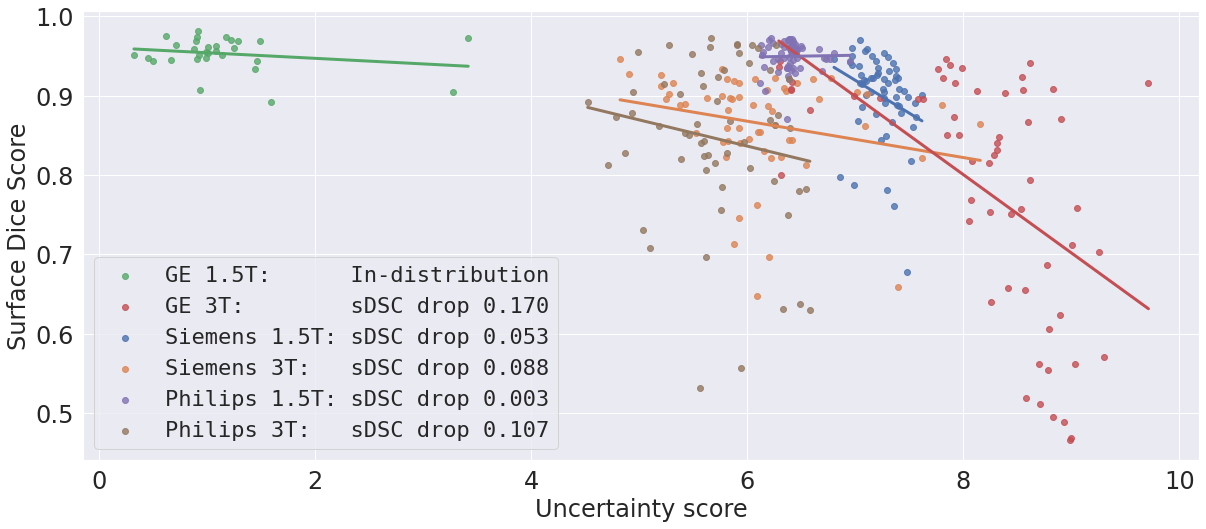

In [131]:
seed = 0
labels = load(os.path.join(f'cc359/svd/experiment_0/test_metrics/min_distance_scale.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))
labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

visualize_ood_statistics_folds(labels, metrics)

In [96]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

exp_dir = '/shared/experiments/ood_playground/cc359/brain_segm/cc359/histograms/experiment_0/'
train_ids = load(os.path.join(exp_dir, f'train_ids.json'))

all_matrix = np.stack([load(os.path.join(exp_dir, f'hist_embeddings/{uid}.npy')) for uid in dataset.ids])

scaler = StandardScaler()
all_matrix = scaler.fit_transform(all_matrix)

In [95]:
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(all_matrix)

In [97]:
tsne = TSNE(n_components=2)
tsne_matrix = tsne.fit_transform(all_matrix)

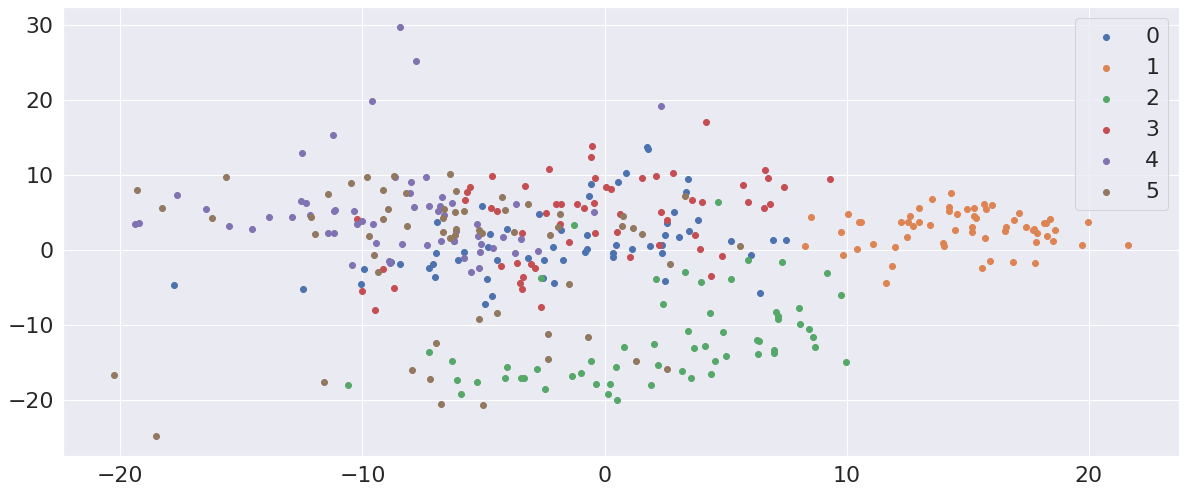

In [101]:
cur_matrix = pca_matrix

for fold in range(6):
    fold_matrix = cur_matrix[dataset.df.fold == fold]
    plt.scatter(fold_matrix[:, 0], fold_matrix[:, 1], label=fold)
    
plt.legend()

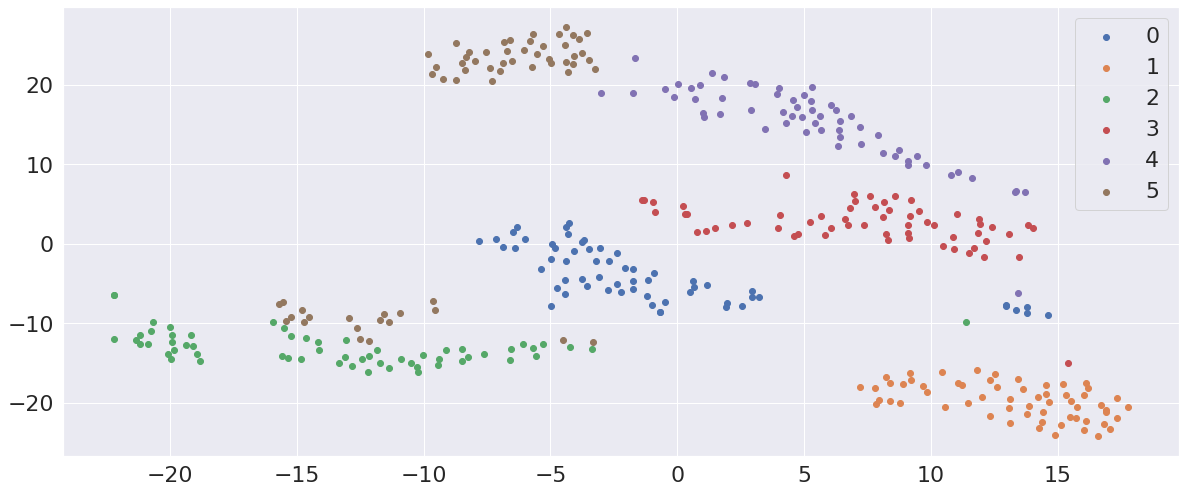

In [102]:
cur_matrix = tsne_matrix

for fold in range(6):
    fold_matrix = cur_matrix[dataset.df.fold == fold]
    plt.scatter(fold_matrix[:, 0], fold_matrix[:, 1], label=fold)
    
plt.legend()

lidc 800
lidc 218
lits 131


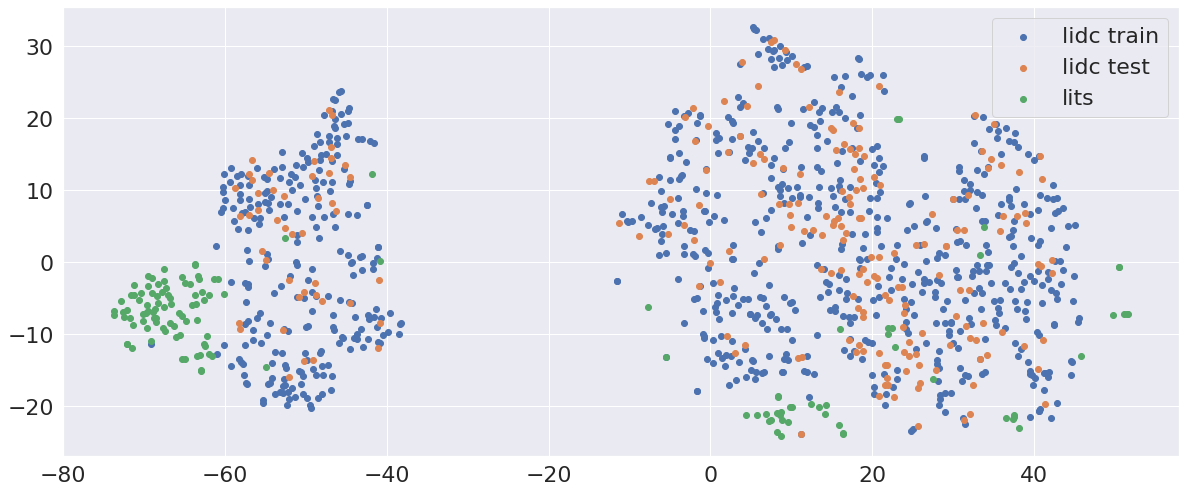

lidc 800
lidc 218
midrc 111


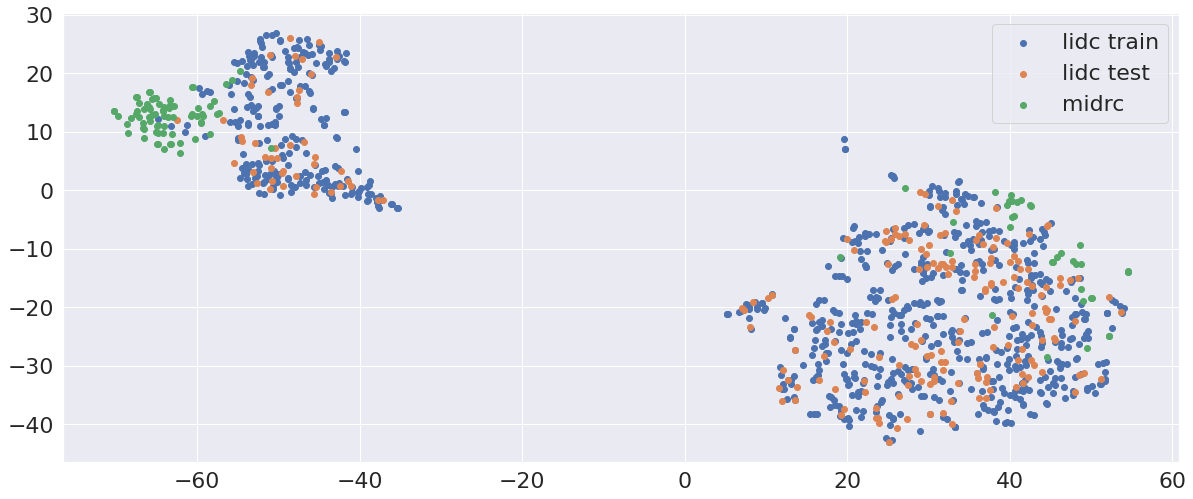

lidc 800
lidc 218
medseg9 9


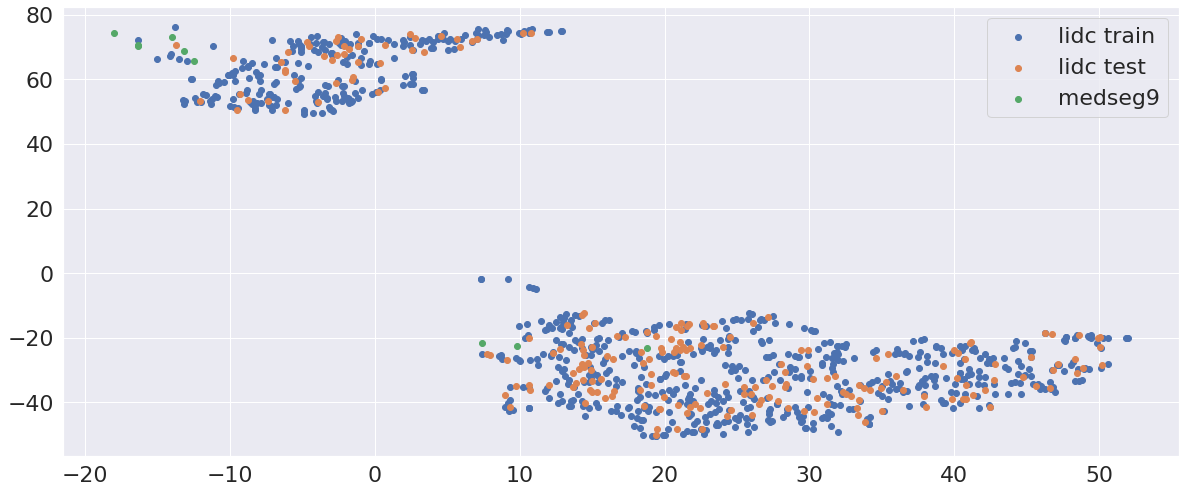

lidc 800
lidc 218
cancer500 841


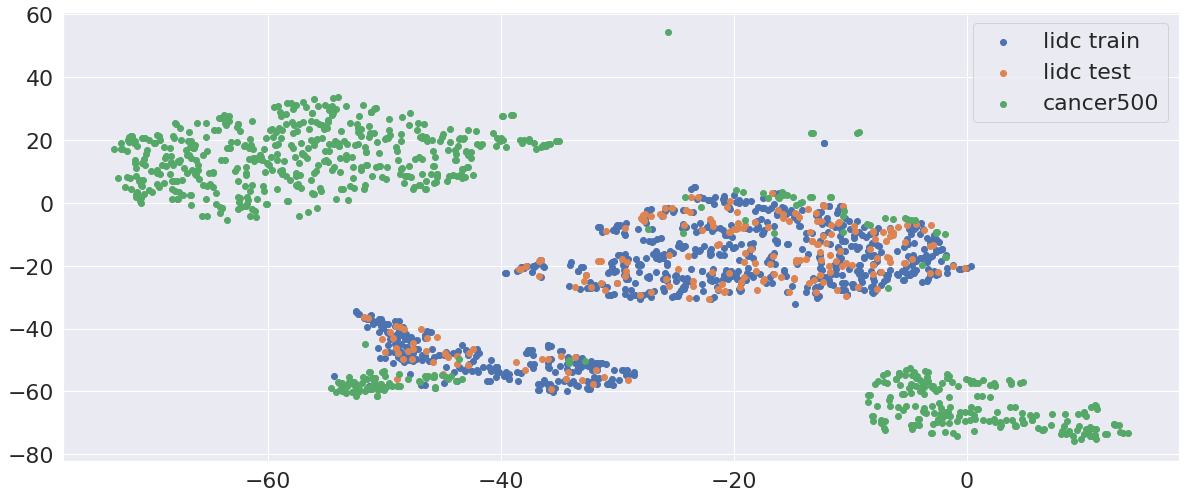

lidc 800
lidc 218
ct_ich 75


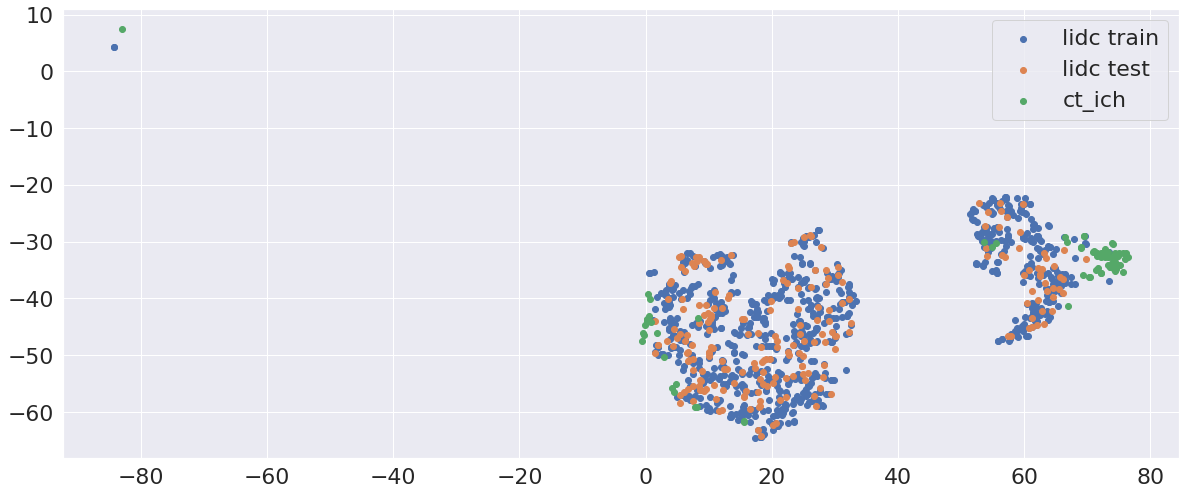

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

exp_dir = '/shared/experiments/ood_playground/lidc/'

n_bins = 200
all_matrix = np.empty((0, n_bins))

# dataset_names = ['luna train', 'luna test', 'lits', 'midrc', 'crop']
for ood_dataset in ['lits', 'midrc', 'medseg9', 'cancer500', 'ct_ich']:
    dataset_names = ['lidc train', 'lidc test', ood_dataset]

    dataset_ids = []
    for dataset_name_full in dataset_names:
        if dataset_name_full.startswith('lidc'):
            fold = dataset_name_full.split(' ')[-1]
            dataset_name = 'lidc'
        else:
            fold = 'test'
            dataset_name = dataset_name_full

        cur_ids = load(os.path.join(exp_dir, dataset_name, f'seed0/experiment_0/{fold}_ids.json'))
        print(dataset_name, len(cur_ids))
        dataset_ids.append(cur_ids)

        cur_matrix = np.stack([load(os.path.join(exp_dir, dataset_name, 
                                                 f'image_statistics/experiment_0/histograms_{n_bins}/{uid}.npy')) 
                               for uid in cur_ids])
        all_matrix = np.vstack([all_matrix, cur_matrix])

    scaler = StandardScaler()
    all_matrix = scaler.fit_transform(all_matrix)
    
    tsne = TSNE(n_components=2)
    tsne_matrix = tsne.fit_transform(all_matrix)
    
    cur_matrix = tsne_matrix

    already_plotted_ids = 0
    for cur_ids, cur_name in zip(dataset_ids, dataset_names):

        fold_matrix = cur_matrix[already_plotted_ids : already_plotted_ids + len(cur_ids)]
        already_plotted_ids += len(cur_ids)
        plt.scatter(fold_matrix[:, 0], fold_matrix[:, 1], label=cur_name)

    plt.legend()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

exp_dir = '/shared/experiments/ood_playground/lidc/'

n_bins = 200
all_matrix = np.empty((0, n_bins))

# dataset_names = ['luna train', 'luna test', 'lits', 'midrc', 'crop']
for ood_dataset in ['lits', 'midrc', 'medseg9', 'cancer500', 'ct_ich']:
    dataset_names = ['lidc train', 'lidc test', ood_dataset]

    dataset_ids = []
    for dataset_name_full in dataset_names:
        if dataset_name_full.startswith('lidc'):
            fold = dataset_name_full.split(' ')[-1]
            dataset_name = 'lidc'
        else:
            fold = 'test'
            dataset_name = dataset_name_full

        cur_ids = load(os.path.join(exp_dir, dataset_name, f'seed0/experiment_0/{fold}_ids.json'))
        print(dataset_name, len(cur_ids))
        dataset_ids.append(cur_ids)

        cur_matrix = np.stack([load(os.path.join(exp_dir, dataset_name, 
                                                 f'image_statistics/experiment_0/histograms_{n_bins}/{uid}.npy')) 
                               for uid in cur_ids])
        all_matrix = np.vstack([all_matrix, cur_matrix])

    scaler = StandardScaler()
    all_matrix = scaler.fit_transform(all_matrix)

In [10]:
tsne = TSNE(n_components=2)
tsne_matrix = tsne.fit_transform(all_matrix)

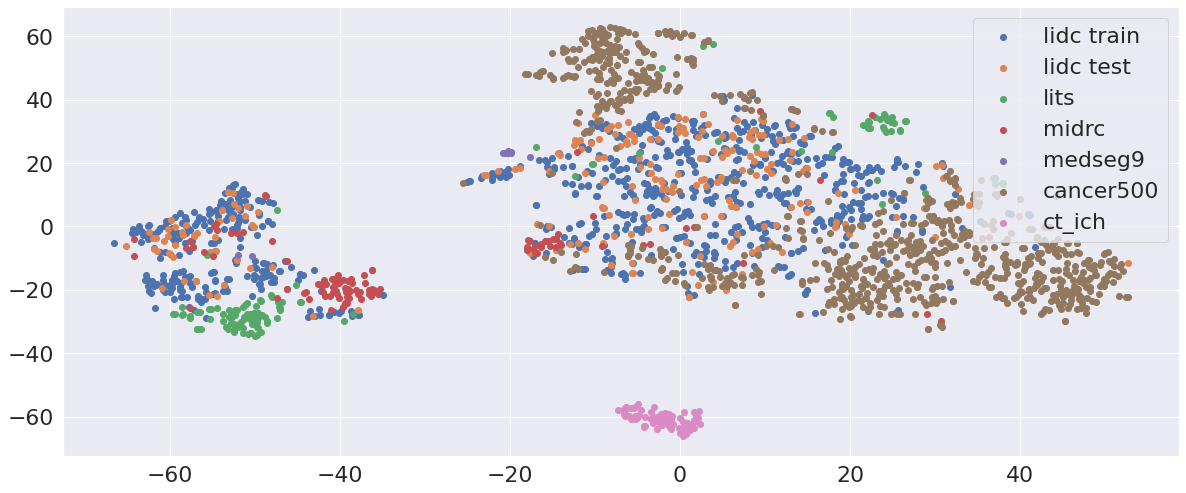

In [11]:
cur_matrix = tsne_matrix

already_plotted_ids = 0
for cur_ids, cur_name in zip(dataset_ids, dataset_names):
    
    fold_matrix = cur_matrix[already_plotted_ids : already_plotted_ids + len(cur_ids)]
    already_plotted_ids += len(cur_ids)
    plt.scatter(fold_matrix[:, 0], fold_matrix[:, 1], label=cur_name)
    
plt.legend()

vsseg 154
vsseg 80
cc359 359
egd 774
crossmoda 484


/homes/dfrolova/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


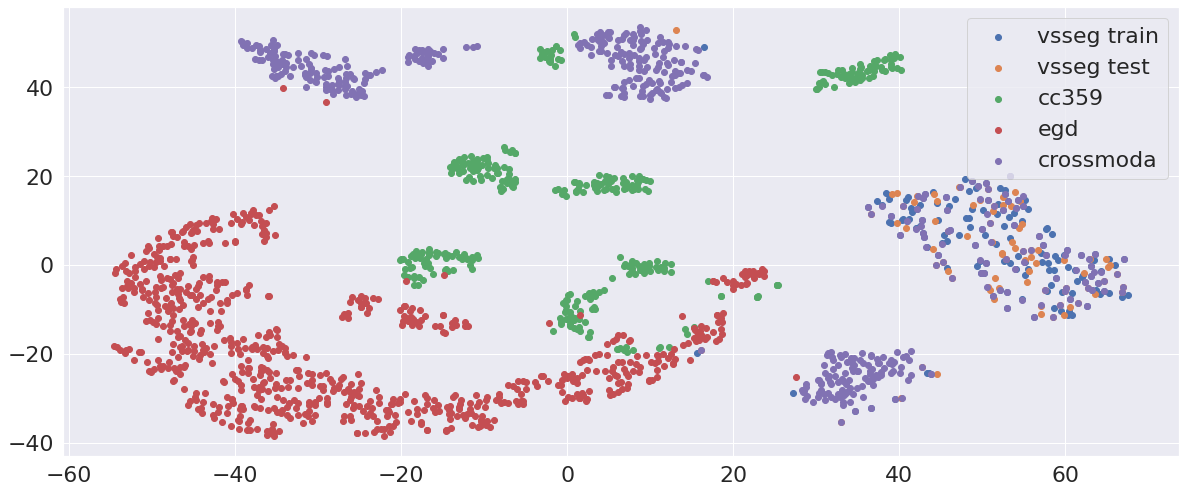

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

exp_dir = '/shared/experiments/ood_playground/vsseg/'

n_bins = 200
all_matrix = np.empty((0, n_bins))

dataset_names = ['vsseg train', 'vsseg test', 'cc359', 'egd', 'crossmoda']

dataset_ids = []
for dataset_name_full in dataset_names:
    if dataset_name_full.startswith('vsseg'):
        fold = dataset_name_full.split(' ')[-1]
        dataset_name = 'vsseg'
    else:
        fold = 'test'
        dataset_name = dataset_name_full

    cur_ids = load(os.path.join(exp_dir, dataset_name, f'image_statistics/experiment_0/{fold}_ids.json'))
    print(dataset_name, len(cur_ids))
    dataset_ids.append(cur_ids)

    cur_matrix = np.stack([load(os.path.join(exp_dir, dataset_name, 
                                             f'image_statistics/experiment_0/histograms_{n_bins}/{uid}.npy')) 
                           for uid in cur_ids])
    all_matrix = np.vstack([all_matrix, cur_matrix])

scaler = StandardScaler()
all_matrix = scaler.fit_transform(all_matrix)

tsne = TSNE(n_components=2)
tsne_matrix = tsne.fit_transform(all_matrix)

cur_matrix = tsne_matrix

already_plotted_ids = 0
for cur_ids, cur_name in zip(dataset_ids, dataset_names):
    
    fold_matrix = cur_matrix[already_plotted_ids : already_plotted_ids + len(cur_ids)]
    already_plotted_ids += len(cur_ids)
    plt.scatter(fold_matrix[:, 0], fold_matrix[:, 1], label=cur_name)
    
plt.legend()

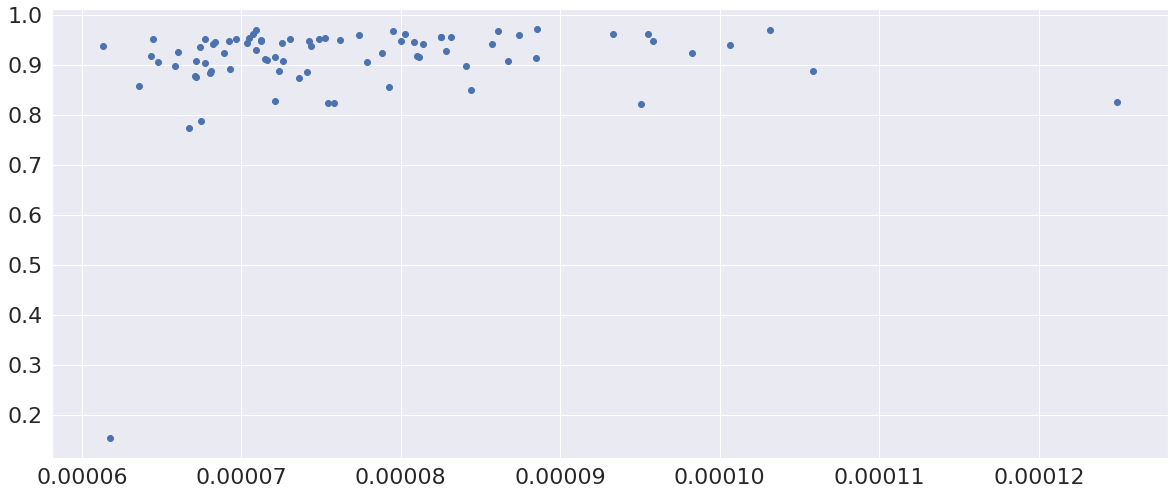

In [19]:
exp_dir = '/shared/experiments/ood_playground/vsseg/vsseg/seed0/experiment_0/test_metrics/'
metrics = load(os.path.join(exp_dir, 'dice_score.json'))
scores = load(os.path.join(exp_dir, 'maxprob.json'))
scores = [scores[uid] for uid in metrics.keys()]

plt.scatter(scores, list(metrics.values()))

In [38]:
from sklearn.model_selection import train_test_split

task = 'brain'

ct_train = [uid for uid in dataset.ids if f'{task}_train' in uid]
ct_toy = [uid for uid in dataset.ids if f'{task}_toy' in uid]
X_train, X_test = train_test_split(ct_train, test_size=100, random_state=42)

save(X_train, f'/shared/experiments/ood_playground/mood/{task}/train_ids.json')
save(X_test + ct_toy, f'/shared/experiments/ood_playground/mood/{task}/test_ids.json')

In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

n_bins = 150
exp_dir = f'/shared/experiments/ood_playground/mood/{task}/scaled_histograms_{n_bins}/experiment_0/hist_embeddings/'

all_ids = os.listdir(exp_dir)
all_matrix = np.stack([load(os.path.join(exp_dir, uid)) for uid in all_ids])

scaler = StandardScaler()
all_matrix = scaler.fit_transform(all_matrix)

In [40]:
tsne = TSNE(n_components=2)
tsne_matrix = tsne.fit_transform(all_matrix)

In [41]:
from amid.mood import MOOD
dataset = MOOD()

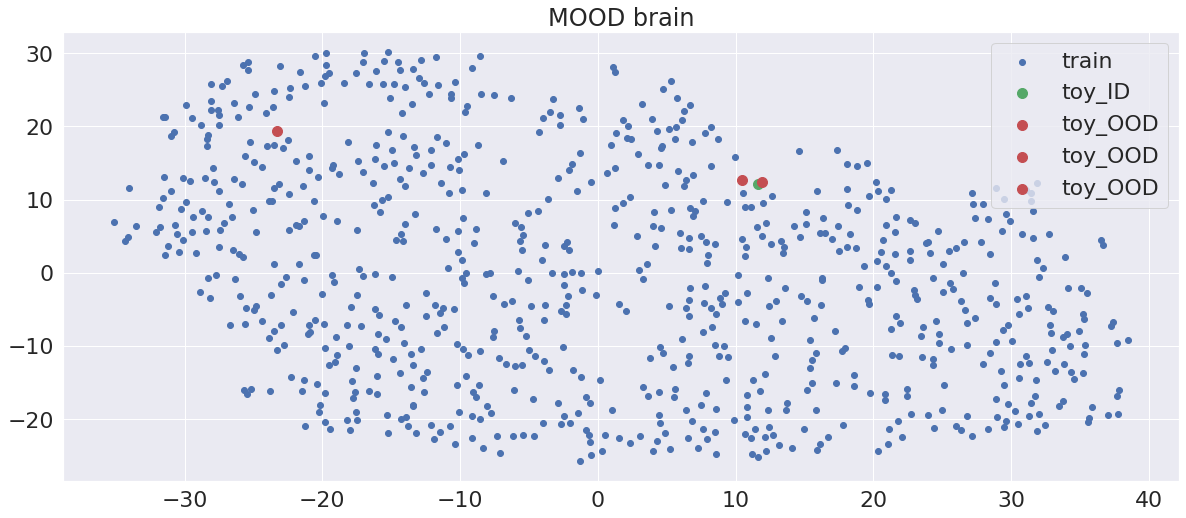

In [44]:
cur_matrix = tsne_matrix

toy_ids = [uid for uid in all_ids if 'toy' in uid]
train_ids = [uid not in toy_ids for uid in all_ids]

plt.scatter(cur_matrix[train_ids, 0], cur_matrix[train_ids, 1], label='train')

id_toy = [uid for uid in toy_ids if dataset.sample_label(uid.split('.')[0]) == '0']
ood_toy = [uid for uid in toy_ids if dataset.sample_label(uid.split('.')[0]) != '0']

for toy_uid in id_toy:
    index = [uid == toy_uid for uid in all_ids]
    plt.scatter(cur_matrix[index, 0], cur_matrix[index, 1], c='g', label=f'toy_ID', s=100)
    
for toy_uid in ood_toy:
    index = [uid == toy_uid for uid in all_ids]
    plt.scatter(cur_matrix[index, 0], cur_matrix[index, 1], c='r', label=f'toy_OOD', s=100)

plt.title(f'MOOD {task}')
plt.legend()

In [9]:
def map_id_ood(fold):
    if fold.startswith('2'):
        return 'ID'
    return 'OOD'


# fold2domain_name = {0: 'Siemens 1.5T', 1: 'Siemens 3T', 2: 'GE 1.5T', 3: 'GE 3T', 4: 'Philips 1.5T', 5: 'Philips 3T'}


def visualize_ood_statistics_folds_separately(labels, metrics):
    fontsize = 12
    
    ood_metrics = np.zeros((n_folds))

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id] = in_distr_metric
    print(f'In distribution: {in_distr_metric:.4f}')

    for fold_id in ood_folds:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id] = ood_metric
        print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    labels_arr = np.array(list(labels.values()))
    folds = np.array([dataset.df.fold[uid] for uid in labels.keys()])
    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
    sorted_ids = np.argsort(labels_arr)

    ordered_metrics = {uid: metrics[uid] for uid in labels.keys()}
    ordered_metrics_arr = np.array(list(ordered_metrics.values()))

    lab_folds = []
    for fold in folds:
        label = f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}'
        if fold == in_distr_id:
            label = f'{fold}: in-distribution'
        lab_folds.append(label)
            
            
    data=pd.DataFrame(np.concatenate([labels_arr[:, None], 
                                      ordered_metrics_arr[:, None]], axis=1))
    data['domains'] = lab_folds
    data = data.sort_values(['domains'])
    data.columns = ['a', 'b', 'Domains']
        
    for ind, cur_domain in enumerate([0, 1, 3, 4, 5]):
        
        ind += 1
        
        cur_data = data[data['Domains'].str.startswith('2') | data['Domains'].str.startswith(str(cur_domain))]
        cur_data['Domains'] = cur_data['Domains'].apply(map_id_ood)
        cur_data = cur_data.sort_values(['Domains'])
    
        plt.figure(figsize=(4, 4))
        if cur_domain == 5:
            sns.lmplot(data=cur_data, x='a', y='b', hue='Domains', aspect=2, size=3.5)
        else:
            sns.lmplot(data=cur_data, x='a', y='b', hue='Domains', aspect=2, size=3.5, legend=False)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Uncertainty score', fontsize=fontsize)
        plt.ylabel('Surface Dice Score', fontsize=fontsize)
        domain_name = fold2domain_name[int(data['Domains'][data['Domains'].str.startswith(str(cur_domain))].iloc[0][0])]
        plt.title(domain_name + f': sDSC drop = {(ood_metrics[in_distr_id] - ood_metrics[cur_domain]):.3f}', 
                  fontsize=fontsize + 2)
        plt.show()

In distribution: 0.9528
OOD fold 0: 0.8998
OOD fold 1: 0.8651
OOD fold 3: 0.7827
OOD fold 4: 0.9494
OOD fold 5: 0.8456


<Figure size 288x288 with 0 Axes>

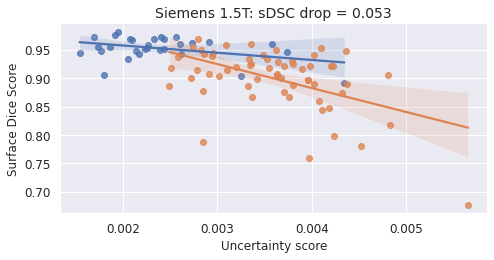

<Figure size 288x288 with 0 Axes>

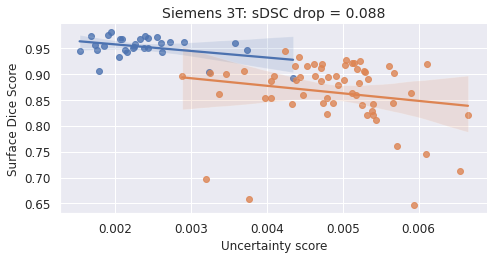

<Figure size 288x288 with 0 Axes>

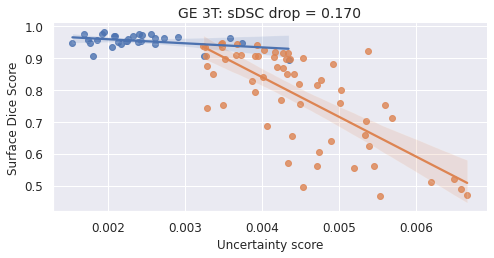

<Figure size 288x288 with 0 Axes>

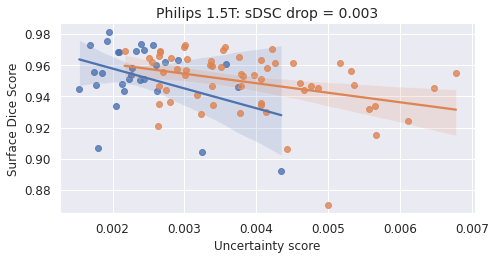

<Figure size 288x288 with 0 Axes>

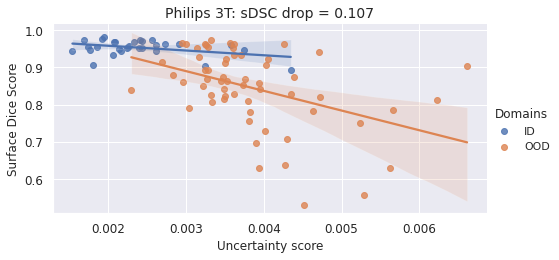

In [11]:
seed = 0
labels = load(os.path.join(experiment_dir, f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))
labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

visualize_ood_statistics_folds_separately(labels, metrics)

In [127]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/'
train_ids = load(os.path.join(experiment_dir, f'cc359/seed{seed}/experiment_0/train_ids.json'))


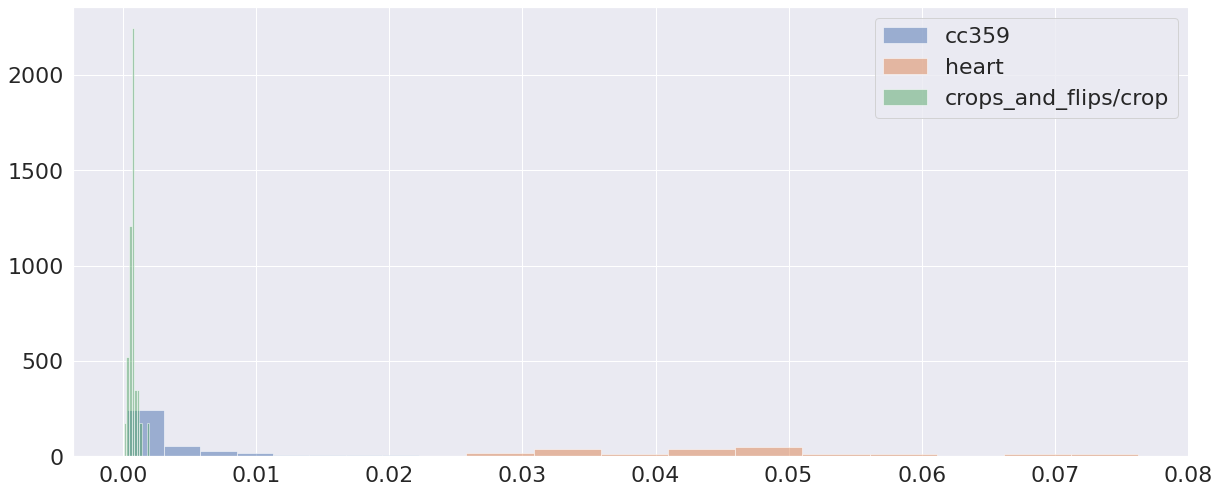

In [69]:
seed = 0

# train_ids = load(os.path.join(experiment_dir, 'cc359', f'seed{seed}/experiment_0/train_ids.json'))
# labels = load(os.path.join(experiment_dir, 'cc359', f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
# labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
# plt.hist(labels.values(), label=dataset_name, alpha=0.5, density=True)

# for dataset_name in ['luna', 'lits', 'flips', 'crop', 'midrc']:
# for dataset_name in ['luna', 'midrc', 'crop', 'lits']:
for dataset_name in ['cc359', 'heart', 'crops_and_flips/crop']:
    # labels = load(os.path.join(experiment_dir, dataset_name, f'embeddings_3/experiment_0/test_metrics/spectrum__min_distance_init.json'))
    labels = load(os.path.join(experiment_dir, dataset_name, f'final_metrics/mut_info.json'))
    # metrics = load(os.path.join(experiment_dir, dataset_name, f'seed{seed}/experiment_0/test_metrics/dice_score.json'))
    
    labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
    
    logbins = np.logspace(np.log10(2 * 1e1), np.log10(1e3), 30)
    
    # plt.hist(labels.values(), label=dataset_name, alpha=0.5, bins=logbins, density=True)
    plt.hist(labels.values(), label=dataset_name, alpha=0.5, density=True)
    
plt.legend()
# plt.xscale('log')

In [121]:
from scipy import stats

In [130]:
seed = 0

# train_ids = load(os.path.join(experiment_dir, 'cc359', f'seed{seed}/experiment_0/train_ids.json'))
# labels = load(os.path.join(experiment_dir, 'cc359', f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
# labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
# plt.hist(labels.values(), label=dataset_name, alpha=0.5, density=True)

# for dataset_name in ['luna', 'lits', 'flips', 'crop', 'midrc']:
for dataset_name in ['cc359']:
    metrics = load(os.path.join(experiment_dir, dataset_name, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
    
    labels_1 = load(os.path.join(experiment_dir, dataset_name, 'final_metrics/var.json'))
    
    for ue_method in ['final_metrics/mut_info.json', 
                      'godin/experiment_0/test_metrics/godin.json',
                      'embeddings_3/experiment_0/test_metrics/spectrum__min_distance_init.json',
                      'embeddings_3/experiment_0/test_metrics/mean__mahalanobis_init.json'
                     ]:
    # for dataset_name in ['cc359', 'heart', 'crops_and_flips/crop']:
        # labels = load(os.path.join(experiment_dir, dataset_name, f'embeddings_3/experiment_0/test_metrics/spectrum__min_distance_init.json'))
        labels = load(os.path.join(experiment_dir, dataset_name, ue_method))

        # if dataset_name == 'heart':
        #     metrics = {uid: }

        labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
        # plt.scatter(labels_1.values(), labels.values(), label=ue_method)
        print(abs(stats.pearsonr(list(metrics.values()), list(labels.values()))[0]), ue_method)

        # logbins = np.logspace(np.log10(2 * 1e1), np.log10(1e3), 30)

        # plt.hist(labels.values(), label=dataset_name, alpha=0.5, bins=logbins, density=True)
        # plt.hist(labels.values(), label=dataset_name, alpha=0.5, density=True)
    
# plt.legend()
# plt.xscale('log')

0.0507490584876983 final_metrics/mut_info.json
0.5042800275633864 godin/experiment_0/test_metrics/godin.json
0.1759133842413657 embeddings_3/experiment_0/test_metrics/spectrum__min_distance_init.json
0.22797959777430143 embeddings_3/experiment_0/test_metrics/mean__mahalanobis_init.json


In [114]:
experiment_dir = 'cc359/svd/experiment_0/'

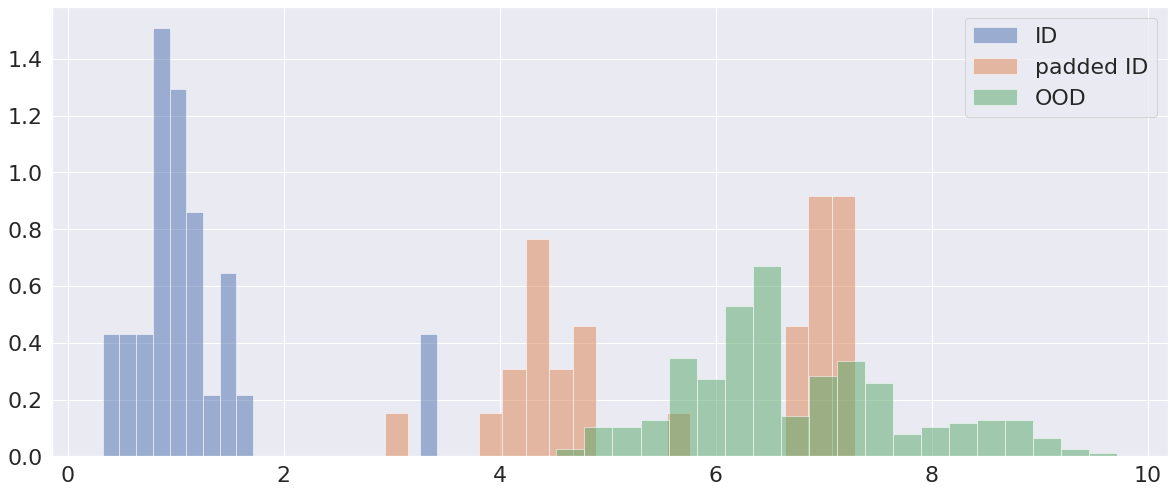

In [126]:
seed = 0

train_ids = load(os.path.join(experiment_dir, f'train_ids.json'))
# labels = load(os.path.join(experiment_dir, 'cc359', f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
# labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
# plt.hist(labels.values(), label=dataset_name, alpha=0.5, density=True)

# for dataset_name in ['luna', 'lits', 'flips', 'crop', 'midrc']:
# for dataset_name in ['lits', 'flips', 'midrc', 'luna']:
# for dataset_name in ['cc359', 'heart', 'crops_and_flips/crop', 'crops_and_flips/flip', 'harp']:
# labels = load(os.path.join(experiment_dir, dataset_name, f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
labels = load(os.path.join(experiment_dir, 'test_metrics/min_distance_scale.json'))
# metrics = load(os.path.join(experiment_dir, dataset_name, f'seed{seed}/experiment_0/test_metrics/dice_score.json'))

labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
labels_keys = set(labels.keys())
id_ids = labels_keys.intersection(ids)
ood_labels = {uid: labels[uid] for uid in labels.keys() if uid not in id_ids}
id_labels = {uid: labels[uid] for uid in labels.keys() if uid in id_ids}


padded_labels = load('cc359/padded_svd/test_metrics/min_distance_scale.json')


# logbins = np.logspace(np.log10(1e-7), np.log10(0.0004), 20)

# plt.hist(labels.values(), label='ID', alpha=0.5, bins=logbins, density=True)
plt.hist(id_labels.values(), label='ID', alpha=0.5, bins=20, density=True)
plt.hist(padded_labels.values(), label='padded ID', alpha=0.5, bins=20, density=True)
plt.hist(ood_labels.values(), label='OOD', alpha=0.5, bins=20, density=True)


    
plt.legend()
# plt.xscale('log')

In [79]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/cc359/'
# experiment_dir = '/shared/experiments/ood_playground/midrc/medseg9'

In [83]:
seed = 0
method2path = {'Baseline': f'seed{seed}/experiment_0/test_metrics/maxprob.json', 
               'Deep Ensembles': 'final_metrics/var.json', 
               'MC-Dropout': 'mc_dropout/experiment_0/test_metrics/var.json',
               'SVD': 'svd_3/experiment_0/test_metrics/min_distance_init.json', 
               'Feature statistics': 'feature_mean_std_3/experiment_0/test_metrics/min_distance_scale.json',
               'image SVD': '/homes/dfrolova/ood-playground/notebooks/image_svd_embeddings/experiment_0/test_metrics_old/min_distance_init.json',
               'image features': '/homes/dfrolova/ood-playground/notebooks/image_features/experiment_0/test_metrics_old/min_distance_scale.json' 
              }

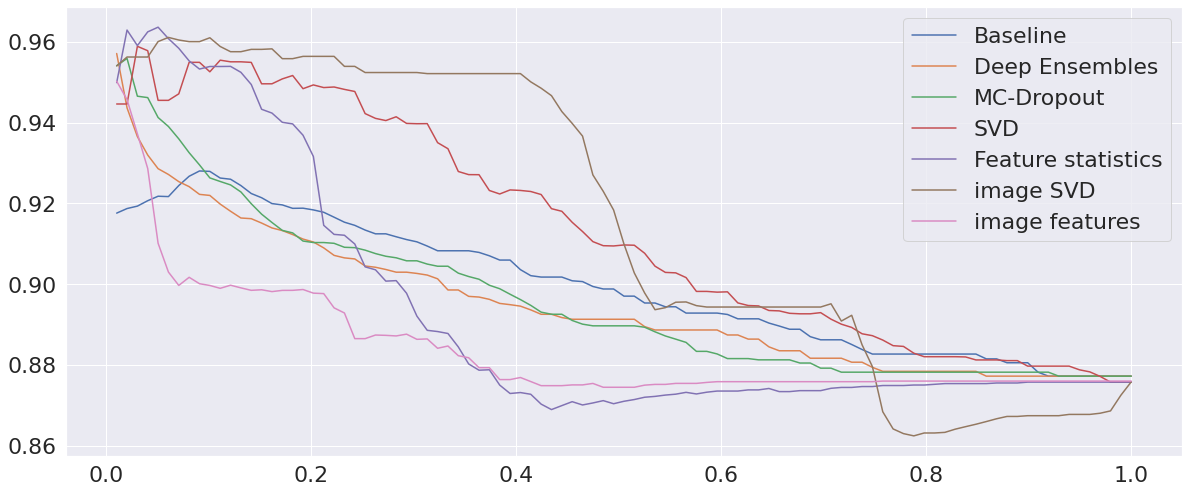

In [85]:
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))

for method in ['Baseline', 'Deep Ensembles', 'MC-Dropout', 'SVD', 'Feature statistics', 'image SVD', 'image features']:

    labels = load(os.path.join(experiment_dir, method2path[method]))
    labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

    min_unc = min(labels.values())
    max_unc = max(labels.values())
    tau_range = np.linspace(min_unc, max_unc, 100)
    acc_metrics = []

    for tau in tau_range:
        accepted_sample_ids = [id_ for id_, unc in labels.items() if unc < tau]
        acc_metric = np.mean([metrics[id_] for id_ in accepted_sample_ids])
        acc_metrics.append(acc_metric)

    plt.plot((tau_range - min_unc) / (max_unc - min_unc), acc_metrics, label=f'{method}')
    
plt.legend()

## Obtaining Deep Ensembles results

Need to provide path `experiment_dir` that contains 5 trained models with predictions in folders `seed0` - `seed4` creates folder `final_metrics` with ood scores of an ensemble inside the `experiment_dir` folder need to do it for all experiments.

In [6]:
def save_ensemble_metrics(exp_dir, n_seeds=5):
    '''
    Function that produces Deep Ensembles OOD scores from 5 trained CNNs. 
    Saves different uncertainty measures to a folder 'final_results' inside 'exp_dir' folder.
    
    Parameters
    ----------
    exp_dir
        path to folder with 5 trained Unets 'seed0' - 'seed4' with different random states.
    
    '''
    
    dices = {}
    sdices = {}
    ensemble_labels = {}
    single_labels = defaultdict(dict)

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = sorted(['.'.join(fname.split('.')[:-1]) for fname in filenames])

    for uid in tqdm(uids):
        ensemble_preds = []
        for seed in range(n_seeds):
            base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            ensemble_preds.append(preds)

        ensemble_preds = np.array(ensemble_preds)
        mean_preds = ensemble_preds.mean(axis=0)
        # single_labels['entropy'][uid] = get_entropy_metric(None, mean_preds)
        # single_labels['maxprob'][uid] = get_maxprob_metric(None, mean_preds)
        # single_labels['mean_of_ones'][uid] = 1 - np.mean(mean_preds[mean_preds > 0.5])
        ensemble_labels[uid] = get_inconsistency_metrics(ensemble_preds, top_n_voxels=TOP_N_VOXELS)

    # save results
    results = ensemble_labels
    if n_seeds == 5:
        results_path = os.path.join(exp_dir, f'final_metrics')
    else:
        results_path = os.path.join(exp_dir, f'final_metrics_{n_seeds}')
    os.makedirs(results_path, exist_ok=True)

    for agg_func_name in results[list(results.keys())[0]].keys():
        result = {_id: results[_id][agg_func_name] for _id in results.keys()}
        save_json(result, os.path.join(results_path, agg_func_name + '.json'), indent=0)
        
    # for metric_name, result in single_labels.items():
    #     save_json(result, os.path.join(results_path, metric_name + '.json'), indent=0)

In [7]:
experiment_dir = '/shared/experiments/ood_playground/lidc/nsclc/'

for i in [2, 3]:
    save_ensemble_metrics(experiment_dir, n_seeds=i)

  0%|          | 0/774 [00:00<?, ?it/s]

/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:99: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
 

  0%|          | 0/774 [00:00<?, ?it/s]

/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:99: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
/homes/dfrolova/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
 

In [18]:
def calc_empty_metrics(exp_dir, n_seeds=3):
    
    dices = {}
    sdices = {}
    ensemble_labels = {}
    single_labels = defaultdict(dict)

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = sorted(['.'.join(fname.split('.')[:-1]) for fname in filenames])

    for seed in range(n_seeds):
        result = {}
        base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
        for uid in tqdm(uids):
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            result[uid] = np.mean(preds > 0.5)

        save_json(result, os.path.join(exp_dir, 
                                       f'seed{seed}/experiment_0/test_metrics/predicted_volume.json'), indent=0)

In [19]:
experiment_dir = '/shared/experiments/ood_playground/vsseg/egd/'
calc_empty_metrics(experiment_dir, n_seeds=3)

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

  0%|          | 0/774 [00:00<?, ?it/s]

## Calculate AUFROC
Provide path to experiment dir that contains 5 trained models with predictions in folders `seed0` - `seed4` for each seed it will create extra json file in `seed{N}/experiment_0/test_metrics/froc_metrics.json` with the required metrics. It is required for segmentation quality drops calculation further need to be done for all LIDC experiments.

In [10]:
luna_path = '/shared/experiments/ood_playground/lidc/nsclc/'
experiments2plot(with_metric=True)

/shared/experiments/ood_playground/lidc/nsclc/seed0
None dl (object Dice): 0.46 +- 0.36
None dl (avg Recall): 0.29 +- 0.01
 
/shared/experiments/ood_playground/lidc/nsclc/seed1
None dl (object Dice): 0.50 +- 0.34
None dl (avg Recall): 0.20 +- 0.01
 
/shared/experiments/ood_playground/lidc/nsclc/seed2
None dl (object Dice): 0.47 +- 0.35
None dl (avg Recall): 0.34 +- 0.01
 


# OOD detection results and drops of segmentation quality
## CC359 brain segmentation
Expected structure of experiments:
```
└── experiment_dir
    ├── CC359
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    ├── heart
    ├── flips
    └── crops
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

In [11]:
# import numpy as np

# from dpipe.dataset.wrappers import apply, cache_methods
# from ood.dataset.heart import Heart
# from ood.dataset.utils import Rescale3D, scale_mri
# from ood.paths import HEART_DATA_PATH


# data_path = HEART_DATA_PATH

# # if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
# voxel_spacing = (1, 0.95, 0.95)

# preprocessed_dataset = apply(Rescale3D(Heart(data_path), voxel_spacing), load_image=scale_mri)
# dataset = apply(preprocessed_dataset, load_image=np.float32)

In [6]:
def save_ensemble_metrics_custom(exp_dir):
    '''
    Function that produces Deep Ensembles OOD scores from 5 trained CNNs. 
    Saves different uncertainty measures to a folder 'final_results' inside 'exp_dir' folder.
    
    Parameters
    ----------
    exp_dir
        path to folder with 5 trained Unets 'seed0' - 'seed4' with different random states.
    
    '''
    
    
    final_path = '/shared/experiments/ood_playground/cc359/brain_segm/visualization/CC0241/'
    # final_path = '/shared/experiments/ood_playground/cc359/brain_segm/visualization/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069/'
    # final_path = '/shared/experiments/ood_playground/cc359/brain_segm/visualization/1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226/'
        
    
    
    dices = {}
    sdices = {}
    ensemble_labels = {}

    base_dir = os.path.join(exp_dir, f'test1/experiment_0/test_predictions')
    # filenames = os.listdir(base_dir)
    # uids = ['CC0241', 'CC0201']
    # uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]
    uids = ['10']

    for uid in tqdm(uids):
        ensemble_preds = []
        for seed in range(n_seeds):
            base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            if seed == 0:
                save(preds, os.path.join(final_path, f'pred_{uid}.npy'))
            ensemble_preds.append(preds)

        ensemble_preds = np.array(ensemble_preds)
        var_preds = ensemble_preds.var(axis=0)
        
        
        save(var_preds, os.path.join(final_path, f'ensemble_{uid}.npy'))
        
        
#         image = dataset.load_image(uid)
#         segm = dataset.load_segm(uid)
#         # segm = np.zeros_like(image)

#         save(image, os.path.join(final_path, f'image_{uid}.npy'))
#         save(segm, os.path.join(final_path, f'mask_{uid}.npy'))

In [1088]:
save_ensemble_metrics_custom('/shared/experiments/ood_playground/cc359/brain_segm/heart/')

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
def filter_emb(results_data):
#     return results_data

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        # results_data.agg_function.str.startswith('min_distance_scale') |\
                        # results_data.agg_function.str.startswith('min_distance_init') |\
                        results_data.agg_function.str.contains('histograms_150__mahalanobis_scale') |
                        results_data.agg_function.str.startswith('var') |
                        results_data.agg_function.str.startswith('std') |
                        results_data.agg_function.str.contains('mut_info') |
                        results_data.agg_function.str.contains('entropy') |
                        results_data.agg_function.str.contains('maxprob') |
                        results_data.agg_function.str.contains('godin') |
                        results_data.agg_function.str.startswith('normalized_spectrum__min_distance_init')
    ].sort_values('AUROC', ascending=False)


def no_filter(results_data):
    return results_data.sort_values('AUROC', ascending=False)

def filter_all(results_data):
#     return results_data

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        # results_data.agg_function.str.startswith('min_distance_scale') |\
                        # results_data.agg_function.str.startswith('min_distance_init') |\
                        ~results_data.agg_function.str.startswith('top_n') &
                        ~results_data.agg_function.str.startswith('mean_of_ones') &
                        # ~results_data.agg_function.str.contains('min_distance_init') &
                        ~results_data.agg_function.str.contains('min_distance_norm') &
                        ~results_data.agg_function.str.contains('5_percentile') & 
                        ~results_data.agg_function.str.startswith('1__') &
                        ~results_data.agg_function.str.startswith('5__')
                        # ~results_data.agg_function.str.endswith('min_distance_norm') &
                        # ~results_data.agg_function.str.contains('mahalanobis') &
                        # results_data.agg_function.str.endswith('min_distance_norm')
                        # results_data.agg_function.str.contains('spectrum__min_distance_init')
                        # ~results_data.agg_function.str.contains('mahalanobis_init')
    ].sort_values(['AUROC', 'TNR @ 95 TPR'], ascending=False)

def filter_new(results_data):
#     return results_data

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        # results_data.agg_function.str.startswith('min_distance_scale') |\
                        # results_data.agg_function.str.startswith('min_distance_init') |\
                        results_data.agg_function.str.startswith('normalized_spectrum__min_distance_init') |
                        results_data.agg_function.str.startswith('min_distance_init') |
                        results_data.agg_function.str.startswith('all__min_distance_scale') |
                        results_data.agg_function.str.startswith('var') |
                        results_data.agg_function.str.startswith('entropy') |
                        results_data.agg_function.str.startswith('maxprob') |
                        results_data.agg_function.str.startswith('mut_info') |
                        results_data.agg_function.str.startswith('godin')
                        # results_data.agg_function.str.startswith('mahalanobis_init')
    ].sort_values('AUROC', ascending=False)


def no_filter(results_data):
    return results_data.sort_values('AUROC', ascending=False)

In [7]:
all_dataframes = {}
collect_results = True

## New benchmark

In [8]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = filter_emb
methods_dict = {
                # 'Deep Ensembles': 'final_metrics', 
                # 'Deep Ensembles 4': 'final_metrics_4',
                'Deep Ensembles 3': 'final_metrics_3',
                'Deep Ensembles 2': 'final_metrics_2',
                'MC-Dropout': 'mc_dropout', 
                # 'image SVD': '/homes/dfrolova/ood-playground/notebooks/image_svd_embeddings/',
                # 'image statistics': '/homes/dfrolova/ood-playground/notebooks/image_features/',
                # 'GODIN': 'godin',
                # 'SVD 19': 'svd_19',
                # 'pNML regret': 'pnml_regret',
                'embeddings 3': 'embeddings_3',
                'embeddings 19': 'embeddings_19',
                'image stats': 'image_statistics',
                # 'Hist 50': 'histograms_50',
                # 'Hist 100': 'histograms_100',
                # 'Hist 150': 'histograms_150',
                # 'Hist 200': 'histograms_200',
                # 'Hist 256': 'histograms_256',
               }

### LIDC

In [9]:
ind_experiment_dir = '/shared/experiments/ood_playground/lidc/lidc'
segm_metrics_froc = ['AvgFP', 'avg_recall']
segm_metrics = []

In [10]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/lidc/lits/', 
                            filter_func=filter_func, data_name='LiTS', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs LiTS'] = result

result


AvgFP
In distr:		3.5673 ± 0.4794
OOD:			10.4529 ± 1.3664
AvgFP drop:	-6.8856 ± 0.9319

avg_recall
In distr:		0.7261 ± 0.0047
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2739 ± 0.0047

LiTS


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
73,image stats,histograms_150__mahalanobis_scale,0.991,0.994,1.000
0,Baseline,maxprob,0.553,0.407,0.117
1,Baseline,entropy,0.557,0.376,0.135


In [11]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/lidc/medseg9/', 
                            filter_func=filter_func, data_name='Medseg9', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs Medseg9'] = result

result


AvgFP
In distr:		3.5673 ± 0.4794
OOD:			13.8148 ± 1.3220
AvgFP drop:	-10.2475 ± 1.6782

avg_recall
In distr:		0.7261 ± 0.0047
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2739 ± 0.0047
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

Medseg9


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
191,image stats,histograms_150__mahalanobis_scale,0.998,0.999,1.000
81,embeddings 19,normalized_spectrum__min_distance_init,0.846,0.894,0.556
37,MC-Dropout,var,0.827,0.865,0.444
9,Deep Ensembles 3,var,0.813,0.845,0.333
41,MC-Dropout,mut_info,0.785,0.841,0.444
13,Deep Ensembles 3,mut_info,0.809,0.828,0.333
7,Deep Ensembles 3,std,0.802,0.815,0.333
35,MC-Dropout,std,0.762,0.813,0.444
8,Deep Ensembles 3,maxprob,0.774,0.792,0.222
36,MC-Dropout,maxprob,0.746,0.792,0.444


In [12]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/lidc/cancer500/', 
                            filter_func=filter_func, data_name='Cancer500', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs Cancer500'] = result

result


AvgFP
In distr:		3.5673 ± 0.4794
OOD:			6.0951 ± 0.6846
AvgFP drop:	-2.5278 ± 0.4004

avg_recall
In distr:		0.7261 ± 0.0047
OOD:			0.3346 ± 0.0121
avg_recall drop:	0.3916 ± 0.0089
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

Cancer500


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
191,image stats,histograms_150__mahalanobis_scale,0.989,0.994,1.000
81,embeddings 19,normalized_spectrum__min_distance_init,0.592,0.592,0.068
23,Deep Ensembles 2,var,0.579,0.576,0.071
27,Deep Ensembles 2,mut_info,0.566,0.566,0.070
37,MC-Dropout,var,0.555,0.564,0.064
9,Deep Ensembles 3,var,0.574,0.563,0.078
13,Deep Ensembles 3,mut_info,0.565,0.559,0.076
41,MC-Dropout,mut_info,0.550,0.558,0.070
7,Deep Ensembles 3,std,0.555,0.547,0.080
21,Deep Ensembles 2,std,0.555,0.547,0.078


In [13]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/lidc/midrc/', 
                            filter_func=filter_func, data_name='MIDRC', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs MIDRC'] = result

result


AvgFP
In distr:		3.5673 ± 0.4794
OOD:			12.3243 ± 1.2282
AvgFP drop:	-8.7570 ± 0.7760

avg_recall
In distr:		0.7261 ± 0.0047
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2739 ± 0.0047
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

MIDRC


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
191,image stats,histograms_150__mahalanobis_scale,0.984,0.995,1.000
22,Deep Ensembles 2,maxprob,0.824,0.893,0.432
21,Deep Ensembles 2,std,0.819,0.891,0.396
7,Deep Ensembles 3,std,0.823,0.889,0.459
27,Deep Ensembles 2,mut_info,0.815,0.885,0.396
13,Deep Ensembles 3,mut_info,0.813,0.882,0.450
8,Deep Ensembles 3,maxprob,0.811,0.879,0.450
23,Deep Ensembles 2,var,0.804,0.878,0.396
9,Deep Ensembles 3,var,0.802,0.870,0.450
45,GODIN,maxprob,0.798,0.844,0.342


In [14]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/lidc/ct_ich/', 
                            filter_func=filter_func, data_name='CT-ICH', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs CT-ICH'] = result

result


AvgFP
In distr:		3.5673 ± 0.4794
OOD:			2.9022 ± 0.8831
AvgFP drop:	0.6651 ± 0.4050

avg_recall
In distr:		0.7261 ± 0.0047
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2739 ± 0.0047
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

CT-ICH


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
191,image stats,histograms_150__mahalanobis_scale,1.000,1.000,1.000
81,embeddings 19,normalized_spectrum__min_distance_init,0.993,0.999,0.987
70,embeddings 19,histograms_150__mahalanobis_scale,0.916,0.962,0.720
44,GODIN,godin,0.905,0.955,0.840
27,Deep Ensembles 2,mut_info,0.817,0.884,0.653
21,Deep Ensembles 2,std,0.822,0.877,0.680
13,Deep Ensembles 3,mut_info,0.805,0.855,0.600
23,Deep Ensembles 2,var,0.806,0.853,0.653
7,Deep Ensembles 3,std,0.814,0.842,0.627
22,Deep Ensembles 2,maxprob,0.815,0.838,0.680


In [15]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/lidc/nsclc/', 
                            filter_func=filter_func, data_name='NSCLC', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs NSCLC'] = result

result


AvgFP
In distr:		3.5673 ± 0.4794
OOD:			11.9510 ± 4.0321
AvgFP drop:	-8.3837 ± 3.5598

avg_recall
In distr:		0.7261 ± 0.0047
OOD:			0.2747 ± 0.0569
avg_recall drop:	0.4514 ± 0.0524
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

NSCLC


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
191,image stats,histograms_150__mahalanobis_scale,0.986,0.992,1.000
29,Deep Ensembles 2,entropy,0.924,0.976,0.872
22,Deep Ensembles 2,maxprob,0.906,0.943,0.590
21,Deep Ensembles 2,std,0.878,0.921,0.359
7,Deep Ensembles 3,std,0.886,0.915,0.381
15,Deep Ensembles 3,entropy,0.875,0.912,0.342
8,Deep Ensembles 3,maxprob,0.873,0.905,0.349
13,Deep Ensembles 3,mut_info,0.866,0.901,0.328
37,MC-Dropout,var,0.857,0.898,0.294
27,Deep Ensembles 2,mut_info,0.848,0.889,0.248


### VS-SEG

In [10]:
ind_experiment_dir = '/shared/experiments/ood_playground/vsseg/vsseg/'
segm_metrics = ['sdice_score', 'dice_score']
segm_metrics_froc = []

In [12]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/vsseg/cc359/', 
                            filter_func=filter_func, data_name='CC359', methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['MRI: VS-SEG vs CC359'] = result

result


sdice_score
In distr:		0.9504 ± 0.0018
OOD:			nan ± nan
sdice_score drop:	nan ± nan

dice_score
In distr:		0.9068 ± 0.0010
OOD:			0.8264 ± 0.1104
dice_score drop:	0.0805 ± 0.1094

CC359


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
73,image stats,histograms_150__mahalanobis_scale,0.994,1.000,1.000
1,Baseline,entropy,0.664,0.504,0.333
0,Baseline,maxprob,0.648,0.363,0.164


In [11]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/vsseg/egd/', 
                            filter_func=filter_func, data_name='EGD', methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['MRI: VS-SEG vs EGD'] = result

result


sdice_score
In distr:		0.9504 ± 0.0018
OOD:			nan ± nan
sdice_score drop:	nan ± nan

dice_score
In distr:		0.9068 ± 0.0010
OOD:			0.5904 ± 0.1697
dice_score drop:	0.3164 ± 0.1690
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

EGD


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
259,image stats,histograms_150__mahalanobis_scale,1.000,1.000,1.000
77,embeddings 3,normalized_spectrum__min_distance_init,1.000,1.000,1.000
138,embeddings 19,histograms_150__mahalanobis_scale,0.973,0.996,0.984
66,embeddings 3,histograms_150__mahalanobis_scale,0.967,0.987,0.983
149,embeddings 19,normalized_spectrum__min_distance_init,0.823,0.887,0.641
29,Deep Ensembles 2,entropy,0.811,0.868,0.145
15,Deep Ensembles 3,entropy,0.698,0.740,0.092
21,Deep Ensembles 2,std,0.613,0.594,0.106
1,Baseline,entropy,0.665,0.556,0.179
22,Deep Ensembles 2,maxprob,0.592,0.550,0.081


In [19]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/vsseg/crossmoda_ldn/', 
                            filter_func=filter_func, data_name='CrossMoDA LDN', methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['MRI: VS-SEG vs CrossMoDA LDN'] = result

result


sdice_score
In distr:		0.9504 ± 0.0018
OOD:			0.9807 ± 0.0016
sdice_score drop:	-0.0303 ± 0.0027

dice_score
In distr:		0.9068 ± 0.0010
OOD:			0.9420 ± 0.0029
dice_score drop:	-0.0351 ± 0.0037

CrossMoDA LDN


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
73,image stats,histograms_150__mahalanobis_scale,0.978,0.984,0.981
0,Baseline,maxprob,0.510,0.468,0.044
1,Baseline,entropy,0.515,0.464,0.041


In [20]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/vsseg/crossmoda_etz/', 
                            filter_func=filter_func, data_name='CrossMoDA ETZ', methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['MRI: VS-SEG vs CrossMoDA ETZ'] = result

result


sdice_score
In distr:		0.9504 ± 0.0018
OOD:			0.9288 ± 0.0007
sdice_score drop:	0.0216 ± 0.0012

dice_score
In distr:		0.9068 ± 0.0010
OOD:			0.8777 ± 0.0028
dice_score drop:	0.0291 ± 0.0018

CrossMoDA ETZ


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
194,image stats,histograms_150__mahalanobis_scale,1.000,1.000,1.000
84,embeddings 19,normalized_spectrum__min_distance_init,1.000,1.000,1.000
31,Deep Ensembles 2,entropy,0.799,0.858,0.333
73,embeddings 19,histograms_150__mahalanobis_scale,0.797,0.852,0.229
22,Deep Ensembles 2,std,0.736,0.805,0.305
23,Deep Ensembles 2,maxprob,0.738,0.798,0.314
7,Deep Ensembles 3,std,0.734,0.797,0.343
16,Deep Ensembles 3,entropy,0.742,0.796,0.333
14,Deep Ensembles 3,mut_info,0.727,0.787,0.324
29,Deep Ensembles 2,mut_info,0.713,0.783,0.305


### Accumulate results

In [21]:
len(all_dataframes)

10

In [22]:
def filter_final(results_data):
    
    methods_agg_dict = {
        'image stats': 'histograms_',
    }

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        # results_data.agg_function.str.startswith('min_distance_scale') |\
                        results_data.agg_function.str.startswith('histograms_')

                        # results_data.agg_function.str.startswith('mahalanobis_init')
    ].sort_values('AUROC', ascending=False)

In [23]:
filter_func = filter_all

In [24]:
# for method_name in [f'Hist {n_bins}' for n_bins in [50, 100, 150, 200, 256]]:
# for method_name in ['SVD 3', 'SVD 19', 'adaBN 3', 'adaBN 19']:
for method_name in ['Deep Ensembles 3', 'Deep Ensembles 2', 'image stats', 'GODIN', 
                    'MC-Dropout', 'embeddings 19']:
    
    print()
    print(method_name)
    print()

    final_dict = defaultdict(list)
    final_dict_auc = defaultdict(list)

    for data_ind, (_, res_data) in enumerate(all_dataframes.items()):
        # if data_ind < 4:
        #     continue
        # if data_ind >= 8:
        #     continue
        res_data = filter_func(res_data[res_data.method == method_name])

        for i, (id_, row) in enumerate(res_data.iterrows()):
            agg = row.agg_function
            final_dict[agg].append(i)
            final_dict_auc[agg].append(1 - row.AUROC)

    sums_dict = {}
    auc_dict = {}

    for key, val in final_dict.items():
        sums_dict[key] = sum(val)
        
    for key, val in final_dict_auc.items():
        auc_dict[key] = sum(val)

    for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
        print(f'{summa}\t{key:30s}\t{final_dict[key]}')
        
    print()
        
    for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
        print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')


Deep Ensembles 3

10	std                           	[1, 2, 2, 0, 1, 0, 1, 1, 2, 0]
16	mut_info                      	[0, 1, 1, 1, 0, 3, 3, 2, 3, 2]
22	entropy                       	[4, 4, 4, 4, 4, 1, 0, 0, 0, 1]
25	maxprob                       	[3, 3, 3, 2, 3, 2, 2, 3, 1, 3]
27	var                           	[2, 0, 0, 3, 2, 4, 4, 4, 4, 4]

3.136	std                           	[1, 2, 2, 0, 1, 0, 1, 1, 2, 0]
3.211	entropy                       	[4, 4, 4, 4, 4, 1, 0, 0, 0, 1]
3.353	mut_info                      	[0, 1, 1, 1, 0, 3, 3, 2, 3, 2]
3.506	maxprob                       	[3, 3, 3, 2, 3, 2, 2, 3, 1, 3]
4.010	var                           	[2, 0, 0, 3, 2, 4, 4, 4, 4, 4]

Deep Ensembles 2

14	std                           	[2, 3, 2, 1, 1, 2, 1, 1, 0, 1]
20	mut_info                      	[1, 1, 1, 2, 0, 3, 3, 3, 3, 3]
20	entropy                       	[3, 4, 4, 4, 4, 0, 0, 0, 1, 0]
21	maxprob                       	[4, 2, 3, 0, 3, 1, 2, 2, 2, 2]
25	var                           	[0

In [25]:
# methods = ['Histogram', 'Deep Ensembles', 'MC-Dropout', 'GODIN']
methods = ['Deep Ensembles 3', 'Deep Ensembles 2', 'image stats', 'GODIN', 
           'MC-Dropout', 'embeddings 19']

final_dict = defaultdict(list)
final_dict_auc = defaultdict(list)

for data_ind, (_, res_data) in enumerate(all_dataframes.items()):

    res_data = filter_func(res_data[res_data.method.isin(methods)])

    for i, (id_, row) in enumerate(res_data.iterrows()):
        agg = str(row.method) + '_' + str(row.agg_function)
        final_dict[agg].append(i)
        final_dict_auc[agg].append(1 - row.AUROC)

sums_dict = {}
auc_dict = {}

for key, val in final_dict.items():
    sums_dict[key] = sum(val)

for key, val in final_dict_auc.items():
    auc_dict[key] = sum(val)

for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa}\t{key:30s}\t{final_dict[key]}')

print()

for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')

0	image stats_histograms_150__mahalanobis_scale	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
58	embeddings 19_normalized_spectrum__min_distance_init	[1, 1, 1, 16, 1, 13, 2, 2, 20, 1]
59	Deep Ensembles 2_std          	[5, 16, 9, 2, 5, 3, 5, 5, 5, 4]
73	Deep Ensembles 2_mut_info     	[4, 14, 3, 4, 4, 9, 7, 7, 12, 9]
73	Deep Ensembles 2_maxprob      	[9, 15, 10, 1, 9, 2, 6, 6, 10, 5]
74	Deep Ensembles 3_std          	[7, 6, 8, 3, 8, 4, 8, 8, 16, 6]
79	Deep Ensembles 3_mut_info     	[6, 5, 6, 5, 6, 7, 10, 9, 17, 8]
86	Deep Ensembles 2_entropy      	[8, 18, 19, 12, 12, 1, 3, 3, 8, 2]
94	Deep Ensembles 2_var          	[3, 10, 2, 7, 7, 11, 17, 11, 14, 12]
103	Deep Ensembles 3_maxprob      	[14, 9, 13, 6, 11, 6, 9, 10, 15, 10]
106	Deep Ensembles 3_var          	[10, 3, 5, 8, 10, 10, 19, 12, 18, 11]
109	MC-Dropout_var                	[11, 2, 4, 10, 16, 8, 20, 18, 7, 13]
112	Deep Ensembles 3_entropy      	[15, 17, 20, 14, 13, 5, 4, 4, 13, 7]
115	embeddings 19_histograms_150__mahalanobis_scale	[13, 20, 18, 20,

#### Final table

In [26]:
sample_dataframe = all_dataframes[list(all_dataframes.keys())[0]].sort_values(['method', 'agg_function'])
columns = sample_dataframe.method
agg_functions = sample_dataframe.agg_function

all_results = pd.DataFrame(columns=[columns, agg_functions], 
                           index=all_dataframes.keys())

for key, res_data in all_dataframes.items():
    all_results.loc[key] = res_data.set_index(['method', 'agg_function']).\
                           sort_values(['method', 'agg_function']).transpose().loc['AUROC']

In [27]:
agg_dict = {'all__min_distance_scale': 'min_sc', 'mut_info': 'MI', 'min_distance_init': 'min',
            'normalized_spectrum__min_distance_init': 'min', 'histograms_150__mahalanobis_scale': 'hist 150 sc'}
method_rename_dict = {'embeddings 19': 'emb 19', 'embeddings 3': 'emb 3'}

all_results.rename(columns=agg_dict, level='agg_function', inplace=True)
all_results.rename(columns=method_rename_dict, level='method', inplace=True)
all_results.drop(columns=[('Deep Ensembles 3', 'maxprob')], inplace=True)
all_results.drop(columns=[('MC-Dropout', 'maxprob')], inplace=True)
all_results.drop(columns=[('GODIN', 'maxprob'), ('GODIN', 'entropy')], inplace=True)

# all_results[('SVD', '3')] = all_results[['emb 3', 'SVD 3']].mean(axis=1)
# all_results[('SVD', '19')] = all_results[['emb 19', 'SVD 19']].mean(axis=1)
# all_results.drop(columns=['SVD 3', 'SVD 19', 'emb 3', 'emb 19'], inplace=True)

all_results

method                       Baseline         Deep Ensembles 2                 \
agg_function                  entropy maxprob          entropy maxprob     MI   
CT: LIDC vs LiTS                0.376   0.407            0.581   0.581  0.613   
CT: LIDC vs Medseg9             0.519   0.674            0.576     0.7  0.705   
CT: LIDC vs Cancer500           0.472   0.505            0.487   0.536  0.566   
CT: LIDC vs MIDRC               0.654   0.797            0.831   0.893  0.885   
CT: LIDC vs CT-ICH              0.566   0.646            0.759   0.838  0.884   
CT: LIDC vs NSCLC                0.59   0.686            0.976   0.943  0.889   
MRI: VS-SEG vs CC359            0.504   0.363             0.94   0.753  0.642   
MRI: VS-SEG vs EGD              0.475   0.308            0.779   0.464  0.457   
MRI: VS-SEG vs CrossMoDA LDN    0.464   0.468            0.465   0.464  0.457   
MRI: VS-SEG vs CrossMoDA ETZ    0.715   0.755            0.858   0.798  0.783   

method                                     Deep Ensembles 3                \
agg_function                    std    var          entropy     MI    std   
CT: LIDC vs LiTS              0.597  0.616            0.415  0.595  0.584   
CT: LIDC vs Medseg9           0.672  0.777            0.647  0.828  0.815   
CT: LIDC vs Cancer500         0.547  0.576            0.479  0.559  0.547   
CT: LIDC vs MIDRC             0.891  0.878             0.82  0.882  0.889   
CT: LIDC vs CT-ICH            0.877  0.853             0.73  0.855  0.842   
CT: LIDC vs NSCLC             0.921  0.874            0.912  0.901  0.915   
MRI: VS-SEG vs CC359          0.803  0.053            0.917   0.45  0.632   
MRI: VS-SEG vs EGD            0.527  0.248            0.619  0.361  0.402   
MRI: VS-SEG vs CrossMoDA LDN  0.468  0.449            0.454  0.429  0.441   
MRI: VS-SEG vs CrossMoDA ETZ  0.805  0.751            0.796  0.787  0.797   

method                               GODIN MC-Dropout                       \
agg_function                    var  godin    entropy     MI    std    var   
CT: LIDC vs LiTS              0.574  0.783      0.194  0.345  0.277  0.497   
CT: LIDC vs Medseg9           0.845  0.512      0.734  0.841  0.813  0.865   
CT: LIDC vs Cancer500         0.563  0.516      0.504  0.558  0.536  0.564   
CT: LIDC vs MIDRC              0.87  0.441      0.507  0.822  0.773  0.837   
CT: LIDC vs CT-ICH            0.821  0.955      0.265  0.505  0.408  0.536   
CT: LIDC vs NSCLC             0.883   0.77      0.004  0.769  0.515  0.898   
MRI: VS-SEG vs CC359          0.042   0.15      0.221  0.101  0.112  0.009   
MRI: VS-SEG vs EGD            0.225  0.197      0.022  0.206  0.131   0.03   
MRI: VS-SEG vs CrossMoDA LDN  0.415  0.467      0.478  0.471  0.475  0.467   
MRI: VS-SEG vs CrossMoDA ETZ  0.752  0.101      0.693  0.741  0.736  0.751   

method                            emb 19        image stats  
agg_function                 hist 150 sc    min hist 150 sc  
CT: LIDC vs LiTS                   0.473  0.883       0.994  
CT: LIDC vs Medseg9                0.483  0.894       0.999  
CT: LIDC vs Cancer500              0.503  0.592       0.994  
CT: LIDC vs MIDRC                  0.432  0.702       0.995  
CT: LIDC vs CT-ICH                 0.962  0.999         1.0  
CT: LIDC vs NSCLC                  0.329  0.778       0.992  
MRI: VS-SEG vs CC359                 1.0  0.979         1.0  
MRI: VS-SEG vs EGD                   1.0  0.971         1.0  
MRI: VS-SEG vs CrossMoDA LDN        0.18  0.156       0.984  
MRI: VS-SEG vs CrossMoDA ETZ       0.852    1.0         1.0

In [161]:
from amid.cc359 import CC359

In [162]:
dataset = CC359()

In [163]:
def get_fold(dataset):
    fold_dict = {
        'philips_15': 4,
        'philips_3': 5,
        'siemens_15': 0,
        'siemens_3': 1,
        'ge_15': 2,
        'ge_3': 3
    }
    return {uid: fold_dict[f'{dataset.vendor(uid)}_{dataset.field(uid)}'] for uid in dataset.ids}

cc359_folds = pd.Series(get_fold(dataset))

### XRay

In [10]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = no_filter
methods_dict = {
                'image stats': 'image_statistics',
               }

In [11]:
from ood.dataset.xray_benchmark.nih import NIHDataset

dataset = NIHDataset('/shared/experiments/ood_playground/xray/nih_dataset/')

In [15]:
ind_experiment_dir = '/shared/experiments/ood_playground/xray/nih/'
test_ids = load(os.path.join(ind_experiment_dir, 'image_statistics/experiment_0/test_ids.json'))
is_ood_id = {uid: uid not in dataset.test_ids_ID for uid in test_ids}

result = get_all_metrics_mood(ind_experiment_dir, filter_func=filter_func, data_name='NIH', 
                              methods_dict=methods_dict, is_ood_id=is_ood_id)

if collect_results:
    all_dataframes['NIH'] = result

result

  0%|          | 0/102 [00:00<?, ?it/s]


NIH


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
32,image stats,spectrum_128__mahalanobis_init,0.552,0.565,0.046
79,image stats,spectrum_128__mahalanobis_scale,0.552,0.565,0.046
61,image stats,spectrum_128__mahalanobis_norm,0.552,0.565,0.046
7,image stats,spectrum_128__min_distance_norm,0.550,0.564,0.063
18,image stats,mean_128__5_percentile_init,0.550,0.563,0.049
...,...,...,...,...,...
16,image stats,normalized_spectrum_256__mahalanobis_norm,0.500,0.442,0.037
101,image stats,normalized_spectrum_256__mahalanobis_scale,0.500,0.442,0.037
2,image stats,normalized_spectrum_128__5_percentile_scale,0.500,0.440,0.042
14,image stats,normalized_spectrum_128__min_distance_norm,0.500,0.438,0.035


# MOOD

In [12]:
from amid.mood import MOOD

dataset = MOOD()

In [33]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = filter_all
methods_dict = {
                # 'Hist 50': 'histograms_50',
                # 'Hist 100': 'histograms_100',
                # 'Hist 150': 'histograms_150',
                # 'Hist 200': 'histograms_200',
                # 'Hist 256': 'histograms_256',
                'scaled Hist 50': 'scaled_histograms_50',
                'scaled Hist 100': 'scaled_histograms_100',
                'scaled Hist 150': 'scaled_histograms_150',
                'scaled Hist 200': 'scaled_histograms_200',
                'scaled Hist 256': 'scaled_histograms_256',
               }

In [30]:
methods_dict = {
                'spectrum 100': 'spectrum_100',
                'norm spectrum 100': 'normalized_spectrum_100',
                'sing vector 100': 'sing_vector_100',
                'mean 100': 'mean_100',
                'mean std 100': 'mean_std_100',
                'spectrum 256': 'spectrum_256',
                'norm spectrum 256': 'normalized_spectrum_256',
                'sing vector 256': 'sing_vector_256',
                'mean 256': 'mean_256',
                'mean std 256': 'mean_std_256',
               }

In [34]:
ind_experiment_dir = '/shared/experiments/ood_playground/mood/abdom'
test_ids = load(os.path.join(ind_experiment_dir, 'test_ids.json'))
is_ood_id = {uid: dataset.fold(uid) == 'toy' and dataset.sample_label(uid) == '1' for uid in test_ids}

result = get_all_metrics_mood(ind_experiment_dir, filter_func=filter_func, data_name='MOOD abdom', 
                              methods_dict=methods_dict, is_ood_id=is_ood_id)

if collect_results:
    all_dataframes['MOOD abdom'] = result

result


MOOD abdom


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,scaled Hist 50,all__mahalanobis_norm,1.000,1.000,1.000
23,scaled Hist 50,all__mahalanobis_scale,1.000,1.000,1.000
27,scaled Hist 100,all__mahalanobis_norm,1.000,1.000,1.000
50,scaled Hist 100,all__mahalanobis_scale,1.000,1.000,1.000
54,scaled Hist 150,all__mahalanobis_norm,1.000,1.000,1.000
77,scaled Hist 150,all__mahalanobis_scale,1.000,1.000,1.000
81,scaled Hist 200,all__mahalanobis_norm,1.000,1.000,1.000
104,scaled Hist 200,all__mahalanobis_scale,1.000,1.000,1.000
108,scaled Hist 256,all__mahalanobis_norm,1.000,1.000,1.000
131,scaled Hist 256,all__mahalanobis_scale,1.000,1.000,1.000


In [35]:
ind_experiment_dir = '/shared/experiments/ood_playground/mood/brain'
test_ids = load(os.path.join(ind_experiment_dir, 'test_ids.json'))
is_ood_id = {uid: dataset.fold(uid) == 'toy' and dataset.sample_label(uid) == '1' for uid in test_ids}

result = get_all_metrics_mood(ind_experiment_dir, filter_func=filter_func, data_name='MOOD brain', 
                              methods_dict=methods_dict, is_ood_id=is_ood_id)

if collect_results:
    all_dataframes['MOOD brain'] = result

result


MOOD brain


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,scaled Hist 50,all__mahalanobis_norm,1.000,1.000,1.000
23,scaled Hist 50,all__mahalanobis_scale,1.000,1.000,1.000
27,scaled Hist 100,all__mahalanobis_norm,1.000,1.000,1.000
50,scaled Hist 100,all__mahalanobis_scale,1.000,1.000,1.000
54,scaled Hist 150,all__mahalanobis_norm,1.000,1.000,1.000
77,scaled Hist 150,all__mahalanobis_scale,1.000,1.000,1.000
81,scaled Hist 200,all__mahalanobis_norm,1.000,1.000,1.000
104,scaled Hist 200,all__mahalanobis_scale,1.000,1.000,1.000
108,scaled Hist 256,all__mahalanobis_norm,1.000,1.000,1.000
131,scaled Hist 256,all__mahalanobis_scale,1.000,1.000,1.000


In [171]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = filter_new
methods_dict = {
                'Deep Ensembles': 'final_metrics', 
                'Deep Ensembles 4': 'final_metrics_4',
                'Deep Ensembles 3': 'final_metrics_3',
                'Deep Ensembles 2': 'final_metrics_2',
                # 'MC-Dropout': 'mc_dropout', 
                # 'adaBN 3': 'feature_mean_std_3',
                # 'adaBN 19': 'feature_mean_std_19',
                # 'Sing vector': 'sing_vectors_3',
                # 'SVD 3': 'svd_3',
                # 'image SVD': '/homes/dfrolova/ood-playground/notebooks/image_svd_embeddings/',
                # 'image statistics': '/homes/dfrolova/ood-playground/notebooks/image_features/',
                # 'GODIN': 'godin',
                # 'SVD 19': 'svd_19',
                # 'pNML regret': 'pnml_regret',
                # 'embeddings 3': 'embeddings_3',
                # 'embeddings 19': 'embeddings_19',
                # 'Hist 50': 'histograms_50',
                # 'Hist 100': 'histograms_100',
                # 'Hist 150': 'histograms_150',
                # 'Hist 200': 'histograms_200',
                # 'Hist 256': 'histograms_256',
               }

In [173]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')
segm_metrics = ['sdice_score']

# dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)

In [174]:
calc_corr = False
if calc_corr:
    COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR', 'Correlation']
else:
    COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']

In [175]:
result = get_all_metrics(ind_experiment_dir, filter_func=filter_func, data_name='CC359 domains', 
                methods_dict=methods_dict, uid_folds=cc359_folds, segm_metrics=segm_metrics,
                calc_corr=calc_corr, corr_segm_metric='sdice_score')

if collect_results:
    all_dataframes['MRI: CC359 domains'] = result

result

SEGMENTATION DROPS

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.8561 ± 0.0599
sdice_score drop:	0.0970 ± 0.0121

CC359 domains


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
55,Deep Ensembles 2,var,0.902,0.956,0.816
59,Deep Ensembles 2,mut_info,0.908,0.951,0.749
10,Deep Ensembles,var,0.900,0.949,0.709
40,Deep Ensembles 3,var,0.903,0.949,0.726
44,Deep Ensembles 3,mut_info,0.910,0.947,0.756
14,Deep Ensembles,mut_info,0.885,0.945,0.739
25,Deep Ensembles 4,var,0.895,0.945,0.702
29,Deep Ensembles 4,mut_info,0.880,0.941,0.709
16,Deep Ensembles,entropy,0.793,0.838,0.569
31,Deep Ensembles 4,entropy,0.795,0.837,0.569


In [79]:
# # filter_func = filter_identity

# experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/spectral_norm/'
# ind_experiment_dir = os.path.join(experiment_dir, 'cc359')

# methods_dict_spec_norm = {k + ' spec_norm': v for k, v in methods_dict.items()}

In [80]:
# result = get_all_metrics(ind_experiment_dir, filter_func=filter_func, data_name='CC359 domains', 
#                 methods_dict=methods_dict_spec_norm, uid_folds=dataset.df['fold'], segm_metrics=segm_metrics, seeds=[0])

# if collect_results:
#     all_dataframes.append(result)

# result

In [81]:
# filter_func(pd.concat([all_dataframes[-2], all_dataframes[-1]]))

In [176]:
result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/crop'),
                            filter_func=filter_func, data_name='CC359 crops',
                            segm_metrics=['sdice_score', 'sdice_score_padded'], 
                            methods_dict=methods_dict, ind_ids_type='CC359', cc359_dataset_folds=cc359_folds,
                            calc_corr=calc_corr, corr_segm_metric='sdice_score')

if collect_results:
    all_dataframes['MRI: CC359 crops'] = result

result


sdice_score
In distr:		0.9531 ± 0.0012
OOD:			nan ± nan
sdice_score drop:	nan ± nan

sdice_score_padded
In distr:		0.9531 ± 0.0012
OOD:			0.7380 ± 0.0009
sdice_score_padded drop:	0.2151 ± 0.0008
Skip mean_volume calculation for Deep Ensembles as it contains Nans
Skip mean_volume calculation for Deep Ensembles 4 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans

CC359 crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
50,Deep Ensembles 2,maxprob,0.833,0.867,0.600
36,Deep Ensembles 3,maxprob,0.833,0.863,0.600
57,Deep Ensembles 2,entropy,0.833,0.859,0.567
22,Deep Ensembles 4,maxprob,0.833,0.857,0.567
0,Baseline,maxprob,0.823,0.855,0.567
8,Deep Ensembles,maxprob,0.833,0.854,0.567
43,Deep Ensembles 3,entropy,0.817,0.850,0.500
29,Deep Ensembles 4,entropy,0.833,0.846,0.433
1,Baseline,entropy,0.813,0.843,0.527
15,Deep Ensembles,entropy,0.817,0.836,0.433


In [83]:
# # filter_func = filter_identity

# experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/spectral_norm/'
# ind_experiment_dir = os.path.join(experiment_dir, 'cc359')

# methods_dict_spec_norm = {k + ' spec_norm': v for k, v in methods_dict.items()}

In [84]:
# result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crop'),
#                             filter_func=filter_func, data_name='CC359 crops', seeds=[0],
#                             segm_metrics=['sdice_score', 'sdice_score_padded'], 
#                             methods_dict=methods_dict_spec_norm, ind_ids_type='CC359', cc359_dataset=dataset, calc_baseline=False)

# if collect_results:
#     all_dataframes.append(result)

# result

In [168]:
result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'heart'), 
                            filter_func=filter_func, data_name='Heart dataset', ind_ids_type='CC359',
                            cc359_dataset_folds=cc359_folds, methods_dict=methods_dict, has_segm_metrics=False,
                            calc_corr=calc_corr, corr_segm_metric='sdice_score')

if collect_results:
    all_dataframes['MRI: heart'] = result

result


Heart dataset


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
14,Deep Ensembles,mut_info,1.0,1.0,1.0
29,Deep Ensembles 4,mut_info,1.0,1.0,1.0
44,Deep Ensembles 3,mut_info,1.0,1.0,1.0
59,Deep Ensembles 2,mut_info,1.0,1.0,1.0


## CC359 hippocampus
Expected structure of experiments:
```
└── experiment_dir
    ├── CC359
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    └── harp
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

In [177]:
experiment_dir = '/shared/experiments/ood_playground/cc359/hippo_segm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')
segm_metrics = ['dice_score']

### HarP hippocampus dataset

In [178]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/cc359/hippo_segm/harp/', 
                            filter_func=filter_func, data_name='HarP dataset', ind_ids_type='CC359', 
                            cc359_dataset_folds=cc359_folds, methods_dict=methods_dict, segm_metrics=segm_metrics,
                            calc_corr=calc_corr, corr_segm_metric='sdice_score')

if collect_results:
    all_dataframes['MRI: HarP'] = result

result


dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.5430 ± 0.0383
dice_score drop:	0.3265 ± 0.0364

HarP dataset


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
29,Deep Ensembles 4,mut_info,0.972,0.992,0.978
14,Deep Ensembles,mut_info,0.965,0.991,0.985
25,Deep Ensembles 4,var,0.974,0.987,0.948
10,Deep Ensembles,var,0.963,0.986,0.956
44,Deep Ensembles 3,mut_info,0.961,0.984,0.956
40,Deep Ensembles 3,var,0.954,0.974,0.941
59,Deep Ensembles 2,mut_info,0.920,0.960,0.874
55,Deep Ensembles 2,var,0.909,0.945,0.881
31,Deep Ensembles 4,entropy,0.881,0.938,0.800
16,Deep Ensembles,entropy,0.876,0.926,0.785


# LIDC

Expected structure of experiments:
```
└── experiment_dir
    ├── luna
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    ├── lits
    ├── flips
    ├── crops
    └── midrc
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

All folders `seed*/experiment_0/test_metrics` should contain `froc_metrics.json` file computed earlier in this notebook. 

In [22]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = filter_all
methods_dict = {
                'Deep Ensembles': 'final_metrics', 
                # 'Deep Ensembles 4': 'final_metrics_4',
                # 'Deep Ensembles 3': 'final_metrics_3',
                # 'Deep Ensembles 2': 'final_metrics_2',
                'MC-Dropout': 'mc_dropout', 
                # 'adaBN 3': 'feature_mean_std_3',
                # 'adaBN 19': 'feature_mean_std_19',
                # 'Sing vector': 'sing_vectors_3',
                # 'SVD 3': 'svd_3',
                # 'image SVD': '/homes/dfrolova/ood-playground/notebooks/image_svd_embeddings/',
                # 'image statistics': '/homes/dfrolova/ood-playground/notebooks/image_features/',
                'GODIN': 'godin',
                # 'SVD 19': 'svd_19',
                # 'pNML regret': 'pnml_regret',
                'embeddings 3': 'embeddings_3',
                'embeddings 19': 'embeddings_19',
                'Hist 50': 'histograms_50',
                'Hist 100': 'histograms_100',
                'Hist 150': 'histograms_150',
                'Hist 200': 'histograms_200',
                'Hist 256': 'histograms_256',
               }

In [179]:
ind_experiment_dir = '/shared/experiments/ood_playground/luna_no_crop/luna'
segm_metrics_froc = ['AvgFP', 'avg_recall']
segm_metrics = []

In [143]:
# all_dataframes = {}

In [180]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna_no_crop/lits/', 
                            filter_func=filter_func, data_name='LiTS', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs LiTS'] = result

result


AvgFP
In distr:		5.9339 ± 2.4190
OOD:			13.3359 ± 4.6312
AvgFP drop:	-7.4019 ± 2.9670

avg_recall
In distr:		0.7163 ± 0.0232
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2837 ± 0.0232

LiTS


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
46,Deep Ensembles 3,entropy,0.817,0.886,0.573
61,Deep Ensembles 2,entropy,0.808,0.882,0.603
31,Deep Ensembles 4,entropy,0.775,0.837,0.534
16,Deep Ensembles,entropy,0.766,0.830,0.519
53,Deep Ensembles 2,maxprob,0.774,0.828,0.374
38,Deep Ensembles 3,maxprob,0.757,0.816,0.267
23,Deep Ensembles 4,maxprob,0.717,0.771,0.206
8,Deep Ensembles,maxprob,0.707,0.761,0.183
59,Deep Ensembles 2,mut_info,0.712,0.758,0.183
44,Deep Ensembles 3,mut_info,0.703,0.733,0.183


In [146]:
# result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/flips/', 
#                             methods_dict=methods_dict, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics,
#                             filter_func=filter_func, data_name='LIDC flips', calc_froc=True)

# if collect_results:
#     all_dataframes.append(result)

# result

In [181]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna_no_crop/crop/', 
                            filter_func=filter_func, data_name='crops', calc_froc=True,
                            methods_dict=methods_dict, has_segm_metrics=True,
                            segm_metrics_froc=['AvgFP', 'avg_recall', 'AvgFP_padded', 'avg_recall_padded'], 
                            segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC crops'] = result

result


AvgFP
In distr:		5.9339 ± 2.4190
OOD:			2.6413 ± 1.0171
AvgFP drop:	3.2927 ± 1.4083

avg_recall
In distr:		0.7163 ± 0.0232
OOD:			0.7610 ± 0.0223
avg_recall drop:	-0.0448 ± 0.0053

AvgFP_padded
In distr:		5.9339 ± 2.4190
OOD:			2.6413 ± 1.0171
AvgFP_padded drop:	3.2927 ± 1.4083

avg_recall_padded
In distr:		0.7163 ± 0.0232
OOD:			0.3851 ± 0.0130
avg_recall_padded drop:	0.3312 ± 0.0113
Skip mean_volume calculation for Deep Ensembles 4 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 3 as it contains Nans
Skip mean_volume calculation for Deep Ensembles 2 as it contains Nans

crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
52,Deep Ensembles 2,var,0.511,0.415,0.064
38,Deep Ensembles 3,var,0.505,0.403,0.050
10,Deep Ensembles,var,0.505,0.402,0.032
24,Deep Ensembles 4,var,0.505,0.392,0.041
56,Deep Ensembles 2,mut_info,0.514,0.383,0.069
58,Deep Ensembles 2,entropy,0.511,0.365,0.055
51,Deep Ensembles 2,maxprob,0.514,0.359,0.069
42,Deep Ensembles 3,mut_info,0.505,0.358,0.055
28,Deep Ensembles 4,mut_info,0.502,0.348,0.041
44,Deep Ensembles 3,entropy,0.511,0.347,0.041


### MIDRC

In [182]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna_no_crop/midrc/', 
                            filter_func=filter_func, data_name='MIDRC', calc_froc=True,
                            methods_dict=methods_dict, has_segm_metrics=True,
                            segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes['CT: LIDC vs MIDRC'] = result

result


AvgFP
In distr:		5.9339 ± 2.4190
OOD:			14.0161 ± 3.7692
AvgFP drop:	-8.0821 ± 1.3527

avg_recall
In distr:		0.7163 ± 0.0232
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2837 ± 0.0232

MIDRC


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
29,Deep Ensembles 4,mut_info,0.791,0.868,0.482
14,Deep Ensembles,mut_info,0.792,0.867,0.429
44,Deep Ensembles 3,mut_info,0.781,0.866,0.500
38,Deep Ensembles 3,maxprob,0.789,0.861,0.500
10,Deep Ensembles,var,0.785,0.850,0.420
8,Deep Ensembles,maxprob,0.787,0.845,0.438
25,Deep Ensembles 4,var,0.779,0.844,0.455
40,Deep Ensembles 3,var,0.768,0.841,0.464
59,Deep Ensembles 2,mut_info,0.768,0.838,0.438
23,Deep Ensembles 4,maxprob,0.786,0.837,0.491


# MIDRC
### Medseg

Expected structure of experiments:
```
└── experiment_dir
    ├── midrc
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    └── medseg9
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

In [183]:
ind_experiment_dir = '/shared/experiments/ood_playground/midrc_no_crop/midrc/'

In [184]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/midrc_no_crop/medseg9/', 
                            filter_func=filter_func, data_name='Medseg9', calc_froc=False,
                            methods_dict=methods_dict, has_segm_metrics=True, segm_metrics=['dice_score'])

if collect_results:
    all_dataframes['CT: MIDRC vs Medseg9'] = result

result


dice_score
In distr:		0.5599 ± 0.0085
OOD:			0.4924 ± 0.0254
dice_score drop:	0.0675 ± 0.0206

Medseg9


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
14,Deep Ensembles,mut_info,0.657,0.599,0.222
44,Deep Ensembles 3,mut_info,0.635,0.594,0.222
29,Deep Ensembles 4,mut_info,0.635,0.585,0.111
10,Deep Ensembles,var,0.635,0.565,0.222
25,Deep Ensembles 4,var,0.635,0.560,0.111
40,Deep Ensembles 3,var,0.614,0.556,0.111
59,Deep Ensembles 2,mut_info,0.635,0.541,0.111
55,Deep Ensembles 2,var,0.614,0.531,0.111
16,Deep Ensembles,entropy,0.614,0.527,0.222
46,Deep Ensembles 3,entropy,0.587,0.493,0.111


In [185]:
len(all_dataframes)

7

In [213]:
sample_dataframe = all_dataframes[list(all_dataframes.keys())[0]].sort_values(['method', 'agg_function'])
columns = sample_dataframe.method
agg_functions = sample_dataframe.agg_function

all_results = pd.DataFrame(columns=[columns, agg_functions], 
                           index=all_dataframes.keys())

for key, res_data in all_dataframes.items():
    all_results.loc[key] = res_data.set_index(['method', 'agg_function']).\
                           sort_values(['method', 'agg_function']).transpose().loc['AUROC']

In [214]:
agg_dict = {'all__min_distance_scale': 'min_sc', 'mut_info': 'MI', 'min_distance_init': 'min',
            'normalized_spectrum__min_distance_init': 'min'}
method_rename_dict = {'embeddings 19': 'emb 19', 'embeddings 3': 'emb 3'}

all_results.rename(columns=agg_dict, level='agg_function', inplace=True)
all_results.rename(columns=method_rename_dict, level='method', inplace=True)
all_results.drop(columns=[('GODIN', 'maxprob'), ('GODIN', 'entropy'), 
                          ('Deep Ensembles', 'maxprob'), ('MC-Dropout', 'maxprob')], inplace=True)

# all_results[('SVD', '3')] = all_results[['emb 3', 'SVD 3']].mean(axis=1)
# all_results[('SVD', '19')] = all_results[['emb 19', 'SVD 19']].mean(axis=1)
# all_results.drop(columns=['SVD 3', 'SVD 19', 'emb 3', 'emb 19'], inplace=True)

all_results

KeyError: ('GODIN', 'maxprob')

In [186]:
def filter_de(results_data):
#     return results_data

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        # results_data.agg_function.str.startswith('min_distance_scale') |\
                        # results_data.agg_function.str.startswith('min_distance_init') |\
                        results_data.agg_function.str.startswith('mut_info') 
                        # results_data.agg_function.str.startswith('mahalanobis_init')
    ].sort_values('AUROC', ascending=False)

In [192]:
# filter_func = filter_iou_top_n
filter_func = filter_de

In [193]:
# for method_name in [f'Hist {n_bins}' for n_bins in [50, 100, 150, 200, 256]]:
# for method_name in ['SVD 3', 'SVD 19', 'adaBN 3', 'adaBN 19']:
for method_name in ['Deep Ensembles', 'Deep Ensembles 4', 'Deep Ensembles 3', 'Deep Ensembles 2']:
    
    print()
    print(method_name)
    print()

    final_dict = defaultdict(list)
    final_dict_auc = defaultdict(list)

    for data_ind, (_, res_data) in enumerate(all_dataframes.items()):
        # if data_ind < 4:
        #     continue
        # if data_ind >= 8:
        #     continue
        res_data = filter_func(res_data[res_data.method == method_name])

        for i, (id_, row) in enumerate(res_data.iterrows()):
            agg = row.agg_function
            final_dict[agg].append(i)
            final_dict_auc[agg].append(1 - row.AUROC)

    sums_dict = {}
    auc_dict = {}

    for key, val in final_dict.items():
        sums_dict[key] = sum(val)
        
    for key, val in final_dict_auc.items():
        auc_dict[key] = sum(val)

    for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
        print(f'{summa}\t{key:30s}\t{final_dict[key]}')
        
    print()
        
    for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
        print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')


Deep Ensembles

0	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

1.909	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

Deep Ensembles 4

0	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

1.828	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

Deep Ensembles 3

0	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

1.751	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

Deep Ensembles 2

0	mut_info                      	[0, 0, 0, 0, 0, 0, 0]

1.783	mut_info                      	[0, 0, 0, 0, 0, 0, 0]


In [194]:
# methods = ['Histogram', 'Deep Ensembles', 'MC-Dropout', 'GODIN']
methods = ['Deep Ensembles', 'Deep Ensembles 4', 'Deep Ensembles 3', 'Deep Ensembles 2']

final_dict = defaultdict(list)
final_dict_auc = defaultdict(list)

for data_ind, (_, res_data) in enumerate(all_dataframes.items()):
    # if data_ind < 4:
    #     continue
    # if data_ind >= 8:
    #     continue
    res_data = filter_func(res_data[res_data.method.isin(methods)])

    for i, (id_, row) in enumerate(res_data.iterrows()):
        agg = str(row.method) + '_' + str(row.agg_function)
        final_dict[agg].append(i)
        final_dict_auc[agg].append(1 - row.AUROC)

sums_dict = {}
auc_dict = {}

for key, val in final_dict.items():
    sums_dict[key] = sum(val)

for key, val in final_dict_auc.items():
    auc_dict[key] = sum(val)

for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa}\t{key:30s}\t{final_dict[key]}')

print()

for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')

9	Deep Ensembles 2_mut_info     	[0, 0, 3, 0, 0, 3, 3]
9	Deep Ensembles 3_mut_info     	[1, 1, 2, 1, 1, 2, 1]
11	Deep Ensembles 4_mut_info     	[3, 2, 0, 2, 2, 0, 2]
13	Deep Ensembles_mut_info       	[2, 3, 1, 3, 3, 1, 0]

1.751	Deep Ensembles 3_mut_info     	[1, 1, 2, 1, 1, 2, 1]
1.783	Deep Ensembles 2_mut_info     	[0, 0, 3, 0, 0, 3, 3]
1.828	Deep Ensembles 4_mut_info     	[3, 2, 0, 2, 2, 0, 2]
1.909	Deep Ensembles_mut_info       	[2, 3, 1, 3, 3, 1, 0]


In [ ]:
dropout - var
ensemble - bald

In [353]:
res_data = all_dataframes[0] # CC359 domains
filter_func(res_data[res_data.method.str.startswith('adaBN 3')])

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
38,adaBN 3,LOF_5_norm,0.955,0.991,0.950
57,adaBN 3,min_distance_norm,0.942,0.982,0.920
46,adaBN 3,LOF_20_norm,0.945,0.981,0.936
44,adaBN 3,min_distance_scale,0.943,0.980,0.920
39,adaBN 3,LOF_10_norm,0.937,0.975,0.903
48,adaBN 3,min_distance_init,0.943,0.968,0.926
43,adaBN 3,mahalanobis_init,0.712,0.570,0.458


In [358]:
res_data = all_dataframes[4] # LIDC vs LiTS
filter_func(res_data[res_data.method.str.startswith('adaBN 3')])

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
39,adaBN 3,mahalanobis_init,0.813,0.873,0.284
36,adaBN 3,LOF_10_norm,0.786,0.852,0.353
29,adaBN 3,LOF_100_scale,0.768,0.841,0.428
42,adaBN 3,LOF_20_norm,0.762,0.831,0.393
30,adaBN 3,LOF_100_norm,0.744,0.826,0.443
35,adaBN 3,LOF_100_init,0.724,0.794,0.398
40,adaBN 3,min_distance_scale,0.724,0.774,0.209
34,adaBN 3,LOF_5_norm,0.707,0.773,0.289
43,adaBN 3,min_distance_init,0.713,0.771,0.269
45,adaBN 3,min_distance_norm,0.720,0.769,0.224


In [107]:
def filter_emb(results_data):
#     return results_data

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        # results_data.agg_function.str.startswith('min_distance_scale') |\
                        # results_data.agg_function.str.startswith('min_distance_init') |\
                        ~results_data.agg_function.str.contains('5_percentile') &\
                        ~results_data.agg_function.str.contains('sing_vector')
                        # results_data.agg_function.str.startswith('mahalanobis_init')
    ].sort_values('AUROC', ascending=False)

In [108]:
filter_func = filter_emb

In [112]:
final_dict = defaultdict(list)
final_dict_auc = defaultdict(list)

for data_ind, res_data in enumerate(all_dataframes):
    # if data_ind < 4:
    #     continue
    res_data = filter_func(res_data[res_data.method == 'embeddings 3'])

    for i, (id_, row) in enumerate(res_data.iterrows()):
        
        agg = row.agg_function
        final_dict[agg].append(i)
        final_dict_auc[agg].append(1 - row.AUROC)

sums_dict = {}
auc_dict = {}

for key, val in final_dict.items():
    sums_dict[key] = sum(val)

for key, val in final_dict_auc.items():
    auc_dict[key] = sum(val)

for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa}\t{key:30s}\t{final_dict[key]}')

print()
print()

for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')

18	normalized_spectrum__min_distance_init	[0, 3, 0, 15]
27	normalized_spectrum__min_distance_scale	[1, 4, 2, 20]
31	normalized_spectrum__min_distance_norm	[2, 5, 3, 21]
31	mean_std__min_distance_scale  	[11, 18, 1, 1]
32	mean_std__mahalanobis_scale   	[8, 11, 7, 6]
33	mean_std__mahalanobis_norm    	[9, 12, 5, 7]
35	normalized_spectrum__mahalanobis_scale	[7, 0, 12, 16]
37	normalized_spectrum__mahalanobis_norm	[5, 1, 14, 17]
37	mean_std__mahalanobis_init    	[10, 13, 6, 8]
39	normalized_spectrum__mahalanobis_init	[6, 2, 13, 18]
39	mean_std__min_distance_norm   	[12, 21, 4, 2]
40	spectrum__min_distance_norm   	[4, 9, 18, 9]
41	mean__mahalanobis_init        	[15, 14, 9, 3]
42	spectrum__min_distance_scale  	[3, 10, 19, 10]
43	mean_std__min_distance_init   	[13, 22, 8, 0]
44	mean__mahalanobis_norm        	[14, 15, 10, 5]
47	mean__mahalanobis_scale       	[16, 16, 11, 4]
55	spectrum__mahalanobis_init    	[17, 6, 21, 11]
61	spectrum__mahalanobis_scale   	[18, 7, 23, 13]
61	spectrum__mahalanobi

In [113]:
final_dict = defaultdict(list)
final_dict_auc = defaultdict(list)

for data_ind, res_data in enumerate(all_dataframes):
    # if data_ind < 4:
    #     continue
    res_data = filter_func(res_data[res_data.method == 'embeddings 19'])

    for i, (id_, row) in enumerate(res_data.iterrows()):
        
        agg = row.agg_function
        final_dict[agg].append(i)
        final_dict_auc[agg].append(1 - row.AUROC)

sums_dict = {}
auc_dict = {}

for key, val in final_dict.items():
    sums_dict[key] = sum(val)

for key, val in final_dict_auc.items():
    auc_dict[key] = sum(val)

for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa}\t{key:30s}\t{final_dict[key]}')

print()
print()

for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')

23	spectrum__min_distance_scale  	[0, 4, 10, 9]
26	spectrum__min_distance_norm   	[1, 3, 12, 10]
28	mean_std__mahalanobis_scale   	[6, 12, 6, 4]
28	mean_std__mahalanobis_norm    	[7, 11, 5, 5]
28	mean_std__mahalanobis_init    	[8, 13, 4, 3]
35	normalized_spectrum__min_distance_init	[3, 7, 11, 14]
36	normalized_spectrum__min_distance_scale	[2, 5, 13, 16]
41	normalized_spectrum__min_distance_norm	[4, 6, 14, 17]
41	normalized_spectrum__mahalanobis_scale	[9, 2, 18, 12]
43	normalized_spectrum__mahalanobis_init	[11, 0, 19, 13]
44	mean_std__min_distance_scale  	[10, 16, 0, 18]
44	normalized_spectrum__mahalanobis_norm	[12, 1, 20, 11]
44	mean__mahalanobis_norm        	[17, 18, 9, 0]
45	mean__mahalanobis_scale       	[19, 17, 7, 2]
46	mean__mahalanobis_init        	[18, 19, 8, 1]
50	spectrum__mahalanobis_init    	[13, 8, 23, 6]
52	spectrum__mahalanobis_norm    	[14, 10, 21, 7]
53	mean_std__min_distance_init   	[5, 22, 3, 23]
53	mean_std__min_distance_norm   	[16, 15, 1, 21]
54	spectrum__mahalano

In [54]:
len(final_dict), len(all_dataframes)

(0, 2)